In [ ]:
# This cell is used to install the necessary Python packages for data analysis and machine learning.
# %pip install numpy
# %pip install pandas==1.3.3
# %pip install matplotlib
# %pip install seaborn
# %pip install sklearn

In [1]:
from sklearn import metrics
import pickle
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

pd.options.mode.chained_assignment = None  # default='warn'

In [242]:
main_directory = '/Volumes/MyBook/justo/oneMINUTE/'

folders = ['results/', 'results_justEN/']
classification_metrics = ['accuracy', 'recall_preictal', 'precision_interictal', 'AUROC']
re_reference_methods = ['monopolar', 'bipolar', 'laplacian']

results = []
for folder in folders:
    for re_reference_method in re_reference_methods:
        
        results_directory = main_directory  + folder + re_reference_method + '/'

        files = listdir(results_directory)

        temp_results = []
        for file in files:
            with open(results_directory+file, 'rb') as f:
                loaded_dict = pd.read_pickle(f)
                temp_results.append(pd.DataFrame(loaded_dict))
                
        results_perRefMethod = pd.concat(temp_results)
        results_perRefMethod['reference'] = re_reference_method
        if folder == 'results/':
            results_perRefMethod['network'] = 'Full'
        elif folder == 'results_justEN/':
            results_perRefMethod['network'] = 'JustEN'
        results_perRefMethod = results_perRefMethod.reset_index(drop=True)
        results.append(results_perRefMethod)

results = pd.concat(results)
results = results.reset_index(drop=True)

classification_methods = results['classification_method'].unique()
FC_methods = results['FC_method'].unique()

del loaded_dict, temp_results, results_perRefMethod, files, main_directory, re_reference_methods, re_reference_method, file, results_directory

In [243]:
# Reformat the results DataFrame for tests
# Pivot the results DataFrame so that each metric becomes a column
results_wide = results.pivot_table(
    index=['patient', 'classification_method', 'FC_method', 'fold', 'train_time', 'reference', 'network'],
    columns='metric',
    values='value',
    aggfunc='first'
).reset_index()

del results

# Optional: flatten the columns if needed
results_wide.columns.name = None

# Change names with underscores
results_wide['FC_method'] = results_wide['FC_method'].str.replace('cross_correlation', 'CrossCorrelation')
results_wide['FC_method'] = results_wide['FC_method'].str.replace('phase_lag', 'PLagI')
results_wide['FC_method'] = results_wide['FC_method'].str.replace('phase_lock', 'PLockV')
results_wide['classification_method'] = results_wide['classification_method'].str.replace('all_interictal', 'DummyAllInterictal')
results_wide['classification_method'] = results_wide['classification_method'].str.replace('all_preictal', 'DummyAllPreictal')
results_wide['classification_method'] = results_wide['classification_method'].str.replace('stratified', 'DummyStratified')

# Extract the part after the first underscore as 'band'
results_wide['band'] = results_wide['FC_method'].str.split('_', n=1).str[1]

# Remove the part after the first underscore (including the underscore) from 'FC_method'
results_wide['FC_method'] = results_wide['FC_method'].str.split('_', n=1).str[0]
# Rename 'FC_method' to 'connectivity'
results_wide = results_wide.rename(columns={'FC_method': 'connectivity'})
# Rename 'FC_method' to 'connectivity'
results_wide = results_wide.rename(columns={'fold': 'Run'})
# Create 'feature' column with the part after the underscore in 'classification_method'
results_wide['classifier'] = results_wide['classification_method'].str.split('_', n=1).str[1]
# Remove the part after the underscore (and the underscore itself) from 'classification_method'
results_wide['feature'] = results_wide['classification_method'].str.split('_', n=1).str[0]
# If connectivity is Dummy, move 'feature' to 'classifier' and set 'feature' to NaN
mask = results_wide['connectivity'] == 'Dummy'
results_wide.loc[mask, 'classifier'] = results_wide.loc[mask, 'feature']
results_wide.loc[mask, 'feature'] = pd.NA
results_wide.loc[mask, 'connectivity'] = pd.NA
# Remove the 'classification_method' column
results_wide = results_wide.drop(columns=['classification_method'])
# Convert metrics to numeric, coercing errors
for metric in ['accuracy', 'recall_preictal', 'precision_interictal', 'AUROC', 'train_time', 'precision_preictal', 'recall_interictal']:
    results_wide[metric] = pd.to_numeric(results_wide[metric], errors='coerce')
# Convert to categorical types
for col in ["reference", "band", "connectivity", "feature", "classifier", "patient", "network"]:
    results_wide[col] = results_wide[col].astype("category")
results_wide = results_wide.reset_index(drop=True) 

del col, metric, mask

In [244]:
# Add PatientCentricScore column to results_wide
# Here, accuracy, precision, and recall are all in [0, 1], so just set weights to sum to 1
w_acc = 0.5
w_prec_inter = 0.2
w_prec_pre = 0.05
w_rec_inter = 0.05
w_rec_pre = 0.2
# All weights sum to 1.0
results_wide['PatientCentricScore'] = (
    w_acc * results_wide['accuracy'] +
    w_prec_inter * results_wide['precision_interictal'] +
    w_prec_pre * results_wide['precision_preictal'] +
    w_rec_inter * results_wide['recall_interictal'] +
    w_rec_pre * results_wide['recall_preictal'])


# 1. Assumptions for ANOVA
Check assumptions to make sure that we can use parametric tests to study the results_wide


=== PatientCentricScore ===
--------------------------------------------------

Step 1: Fitting the ANOVA model for main effects...

N-Way ANOVA Results (Main Effects):
                      sum_sq       df             F         PR(>F)
C(reference)       30.131541      2.0    474.725015  8.750880e-206
C(band)             4.972504      6.0     26.114074   3.187177e-31
C(connectivity)   353.491571      4.0   2784.645001   0.000000e+00
C(feature)          7.061744      1.0    222.516773   2.947273e-50
C(classifier)    2428.901120      1.0  76535.090622   0.000000e+00
C(network)         49.944800      1.0   1573.769201   0.000000e+00
Residual         2771.930335  87344.0           NaN            NaN
--------------------------------------------------

Step 2: Checking model assumptions...
Checking for Normality of Residuals...
Shapiro-Wilk Test for Normality: W=0.9844, p-value=5.858979744552497e-65
 ✗ Warning: Residuals may not be normally distributed (p < 0.05). Consider data transformati

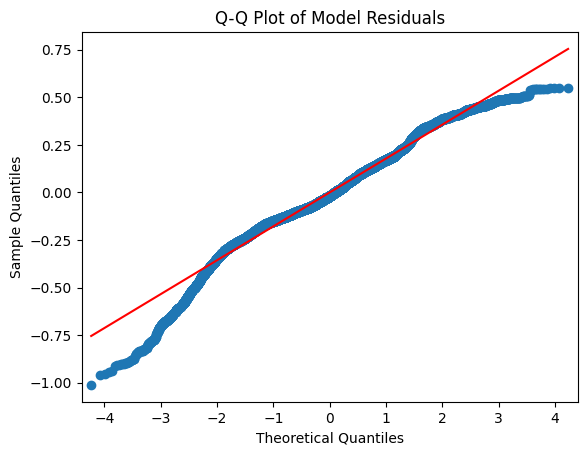


Checking for Homogeneity of Variances (Homoscedasticity)...
Levene's Test for 'reference': Statistic=509.4118, p-value=1.110282513382642e-220
 ✗ Warning: Variances may not be equal across levels of 'reference' (p < 0.05).


Levene's Test for 'band': Statistic=21.3143, p-value=3.7428546476790224e-25
 ✗ Warning: Variances may not be equal across levels of 'band' (p < 0.05).


Levene's Test for 'connectivity': Statistic=707.0784, p-value=0.0
 ✗ Warning: Variances may not be equal across levels of 'connectivity' (p < 0.05).


Levene's Test for 'feature': Statistic=1633.0663, p-value=0.0
 ✗ Warning: Variances may not be equal across levels of 'feature' (p < 0.05).


Levene's Test for 'classifier': Statistic=968.0932, p-value=2.230673090850038e-211
 ✗ Warning: Variances may not be equal across levels of 'classifier' (p < 0.05).


Levene's Test for 'network': Statistic=181.9274, p-value=2.0235973687734908e-41
 ✗ Warning: Variances may not be equal across levels of 'network' (p < 0.05).


---

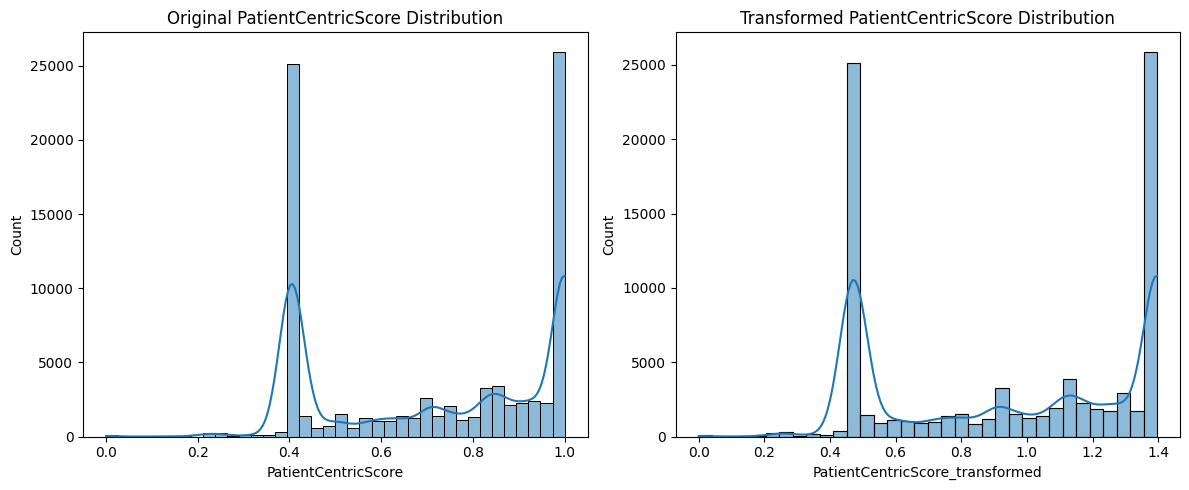

--------------------------------------------------

Step 3: Fitting the ANOVA model on the TRANSFORMED data...

N-Way ANOVA Results (on Transformed Data):
                      sum_sq       df             F         PR(>F)
C(reference)       67.239685      2.0    441.254921  2.123602e-191
C(band)            11.367435      6.0     24.865953   1.215658e-29
C(connectivity)   839.289615      4.0   2753.884649   0.000000e+00
C(feature)         12.515457      1.0    164.263319   1.432663e-37
C(classifier)    5804.207637      1.0  76179.273628   0.000000e+00
C(network)        120.477233      1.0   1581.243932   0.000000e+00
Residual         6654.864082  87344.0           NaN            NaN

Now, let's re-check the assumptions with the new model...

Checking for Normality of Residuals (Transformed Data)...
Shapiro-Wilk Test: W=0.9870, p-value=0.0000


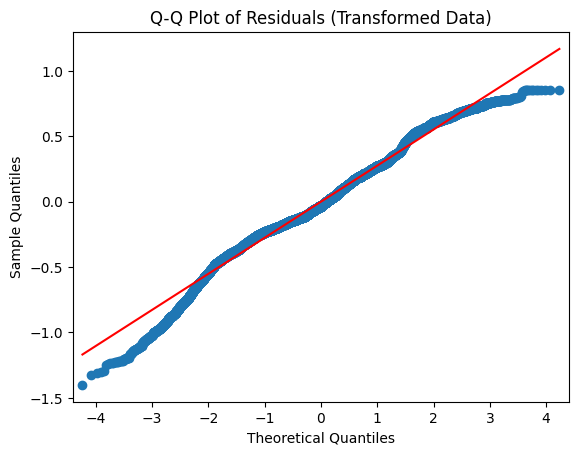


Checking for Homogeneity of Variances (Transformed Data)...
Levene's Test for 'reference': Statistic=488.8382, p-value=7.576392425682903e-212
 ✗ Warning: Variances may still not be equal across levels of 'reference' (p < 0.05).
Levene's Test for 'band': Statistic=20.0506, p-value=1.4627374621110522e-23
 ✗ Warning: Variances may still not be equal across levels of 'band' (p < 0.05).
Levene's Test for 'connectivity': Statistic=562.7842, p-value=0.0
 ✗ Warning: Variances may still not be equal across levels of 'connectivity' (p < 0.05).
Levene's Test for 'feature': Statistic=1815.7276, p-value=0.0
 ✗ Warning: Variances may still not be equal across levels of 'feature' (p < 0.05).
Levene's Test for 'classifier': Statistic=455.6792, p-value=7.594440646581561e-101
 ✗ Warning: Variances may still not be equal across levels of 'classifier' (p < 0.05).
--------------------------------------------------

=== ALTERNATIVE TRANSFORMATION APPROACHES ===

NORMALITY TESTS FOR DIFFERENT TRANSFORMATION

In [299]:
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import shapiro, levene, boxcox

# Remove the Dummy classifiers from the results_wide DataFrame
results_wide_all = results_wide.__deepcopy__()
results_wide = results_wide[~results_wide['classifier'].str.contains('Dummy')]
# Remove unused categories from the 'classifier' column
results_wide['classifier'] = results_wide['classifier'].cat.remove_unused_categories()

metrics = ['PatientCentricScore']
factors = ['reference', 'band', 'connectivity', 'feature', 'classifier', 'network']

for metric in metrics:
    print(f"\n=== {metric} ===")
    print("-" * 50)
    
    print("\nStep 1: Fitting the ANOVA model for main effects...")
    formula = f'{metric} ~ C(reference) + C(band) + C(connectivity) + C(feature) + C(classifier) + C(network)'
    model = ols(formula, data=results_wide).fit()
    # Perform the ANOVA
    # We use Type 2 ANOVA, which is appropriate for unbalanced designs when you
    # are primarily interested in main effects (assuming no major interactions).
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("\nN-Way ANOVA Results (Main Effects):")
    print(anova_table)
    print("-" * 50)

    # --- Checking ANOVA Assumptions ---------------------------------------------------------------------------------
    print("\nStep 2: Checking model assumptions...")

    # Assumption 1: Normality of Residuals
    print("Checking for Normality of Residuals...")
    residuals = model.resid
    w, p_value_shapiro = shapiro(residuals)
    print(f"Shapiro-Wilk Test for Normality: W={w:.4f}, p-value={p_value_shapiro}")
    if p_value_shapiro < 0.05:
        print(" ✗ Warning: Residuals may not be normally distributed (p < 0.05). Consider data transformation.")
    else:
        print(" ✓ Success: Residuals appear to be normally distributed (p >= 0.05).")
    # Visualize normality with a Q-Q plot
    sm.qqplot(residuals, line='s')
    plt.title("Q-Q Plot of Model Residuals")
    plt.show()

    # Assumption 2: Homogeneity of Variances
    print("\nChecking for Homogeneity of Variances (Homoscedasticity)...")
    # We test this for the factor with the most significant effect or most levels. Let's use 'Connectivity'.
    # Note: A proper Levene test should check variance across all combined groups, which is more complex.
    # A simpler, common approach is to check against each factor individually.
    all_groups = []
    for factor in factors:
        groups = [results_wide[metric][results_wide[factor] == level] for level in results_wide[factor].unique()]
        stat, p_value_levene = levene(*groups)
        print(f"Levene's Test for '{factor}': Statistic={stat:.4f}, p-value={p_value_levene}")
        if p_value_levene < 0.05:
            print(f" ✗ Warning: Variances may not be equal across levels of '{factor}' (p < 0.05).")
        else:
            print(f" ✓ Success: Variances appear equal for '{factor}' (p >= 0.05).")
        print("\n")
    print("-" * 50)

    # --- Handling Assumption Violations with Data Transformation ---------------------------------------------------------
    print("\nStep 3: Applying Box-Cox Transformation to address assumption violations...")
    # The Box-Cox transformation requires all results_wide to be positive.
    # If your performance can be 0, we must add a small constant.
    if (results_wide[metric] <= 0).any():
        print(f"{metric} data contains zero or negative values. Adding a small constant (1) before transformation.")
        performance_positive = results_wide[metric] + 1
    else:
        performance_positive = results_wide[metric]

    # Apply the Box-Cox transformation
    transformed_perf, best_lambda = boxcox(performance_positive)
    results_wide[f'{metric}_transformed'] = transformed_perf
    print(f"Box-Cox transformation applied with optimal lambda = {best_lambda:.4f}")

    # Visualize original vs. transformed data distributions
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(results_wide[metric], kde=True, ax=axes[0]).set_title(f'Original {metric} Distribution')
    sns.histplot(results_wide[f'{metric}_transformed'], kde=True, ax=axes[1]).set_title(f'Transformed {metric} Distribution')
    plt.tight_layout()
    plt.show()
    print("-" * 50)

    # --- Re-run ANOVA and Assumption Checks on Transformed Data ---------------------------------------------------------
    print("\nStep 3: Fitting the ANOVA model on the TRANSFORMED data...")
    formula_t = f'{metric}_transformed ~ C(reference) + C(band) + C(connectivity) + C(feature) + C(classifier) + C(network)'
    model_t = ols(formula_t, data=results_wide).fit()
    anova_table_t = sm.stats.anova_lm(model_t, typ=2)

    print("\nN-Way ANOVA Results (on Transformed Data):")
    print(anova_table_t)
    print("\nNow, let's re-check the assumptions with the new model...")

    # Assumption 1: Normality of Residuals
    print("\nChecking for Normality of Residuals (Transformed Data)...")
    residuals_t = model_t.resid
    w, p_value_shapiro = shapiro(residuals_t)
    print(f"Shapiro-Wilk Test: W={w:.4f}, p-value={p_value_shapiro:.4f}")
    if p_value_shapiro < 0.05:
        print("Warning: Residuals may still not be normally distributed (p < 0.05).")
    else:
        print("Success: Residuals appear to be normally distributed (p >= 0.05).")

    # Visualize normality with a Q-Q plot
    sm.qqplot(residuals_t, line='s')
    plt.title("Q-Q Plot of Residuals (Transformed Data)")
    plt.show()

    # Assumption 2: Homogeneity of Variances
    print("\nChecking for Homogeneity of Variances (Transformed Data)...")
    for factor in ['reference', 'band', 'connectivity', 'feature', 'classifier']:
        # Ensure there's data for all levels to avoid NaN issues with Levene's test
        if results_wide[factor].nunique() > 1:
            groups = [results_wide[f'{metric}_transformed'][results_wide[factor] == level] for level in results_wide[factor].unique()]
            stat, p_value_levene = levene(*groups)
            print(f"Levene's Test for '{factor}': Statistic={stat:.4f}, p-value={p_value_levene}")
            if p_value_levene < 0.05:
                print(f" ✗ Warning: Variances may still not be equal across levels of '{factor}' (p < 0.05).")
            else:
                print(f" ✓ Success: Variances appear equal for '{factor}' (p >= 0.05).")
    print("-" * 50)


    # --- Try alternative data transformations if Box-Cox failed ---------------------------------------------------------
    print("\n=== ALTERNATIVE TRANSFORMATION APPROACHES ===\n")

    # Original data
    original_data = results_wide[metric].values

    transformations = {
        'Log': np.log(original_data + 1e-8),  # Add small constant to avoid log(0)
        'Square root': np.sqrt(original_data),
        'Arcsine': np.arcsin(np.sqrt(original_data)),  # Good for proportions
        'Logit': np.log(original_data / (1 - original_data + 1e-8)),  # For bounded data
        'Rank': stats.rankdata(original_data)
    }

    print("NORMALITY TESTS FOR DIFFERENT TRANSFORMATIONS:")
    print("-" * 50)
    print(f"{'Transformation':<15} {'Shapiro-W':<12} {'p-value':<22} {'Normal?'}")
    print("-" * 50)

    # Test original data
    w_orig, p_orig = stats.shapiro(original_data)
    normal_orig = "Yes" if p_orig > 0.05 else "No"
    print(f"{'Original':<15} {w_orig:<12.4f} {p_orig:<22} {normal_orig}")

    best_transformation = None
    best_p_value = p_orig

    for trans_name, trans_data in transformations.items():
        # Skip if transformation produces invalid values
        if np.any(np.isnan(trans_data)) or np.any(np.isinf(trans_data)):
            print(f"{trans_name:<15} {'Invalid':<12} {'N/A':<12} {'No'}")
            continue
            
        w_stat, p_value = stats.shapiro(trans_data)
        normal = "Yes" if p_value > 0.05 else "No"
        print(f"{trans_name:<15} {w_stat:<12.4f} {p_value:<22} {normal}")
        
        if p_value > best_p_value:
            best_p_value = p_value
            best_transformation = (trans_name, trans_data)

    if best_transformation:
        print(f"\nBest transformation: {best_transformation[0]} (p = {best_p_value})")
        if best_p_value > 0.05:
            print(" ✓ This transformation achieves normality!")
            # return best_transformation[0], best_transformation[1]
        else:
            print(" ✗ No transformation achieves normality - proceed with non-parametric tests")
    else:
        print(" ✗ No valid transformations found - proceed with non-parametric tests")



# 2. Non parametric main effects analysis
Given that ANOVA assumptions are violated even after transformations, we replace with Kruskall-Wallis tests that is a non-parametric alternative to one-way ANOVA that requires no assumptions about normality or equal variances.

POST-HOC ANALYSIS:
 Mann-Whitney U tests with correction
- For pairwise comparisons when Kruskal-Wallis is significant
- Apply Bonferroni correction for multiple comparisons
- Effect size: rank-biserial correlation (r)

INTERPRETATION GUIDELINES:
- ε² < 0.01: negligible effect
- ε² 0.01-0.06: small effect  
- ε² 0.06-0.14: medium effect
- ε² > 0.14: large effect

- |r| < 0.1: negligible effect
- |r| 0.1-0.3: small effect
- |r| 0.3-0.5: medium effect  
- |r| > 0.5: large effect

In [246]:
metric = 'PatientCentricScore'
print(f"\n=== Non-parametric tests for {metric} ===")

nonparametric_results = {}
for factor in factors:
    print(f"KRUSKAL-WALLIS TEST: {factor}")
    print("-" * 50)

    # Prepare groups for Kruskal-Wallis test
    groups = [group[metric].values for name, group in results_wide.groupby(factor)]
    group_names = [name for name, group in results_wide.groupby(factor)]

    # Perform Kruskal-Wallis test
    h_stat, p_value = stats.kruskal(*groups)

    print(f"H-statistic: {h_stat:.4f}")
    print(f"P-value: {p_value}")

    # Effect size (epsilon-squared for Kruskal-Wallis)
    n_total = len(results_wide)
    k = len(groups)  # number of groups
    epsilon_squared = (h_stat - k + 1) / (n_total - k)

    print(f"Effect size (ε²): {epsilon_squared:.4f}")

    # Interpretation of effect size
    if epsilon_squared < 0.01:
        effect_size_interpretation = "negligible"
    elif epsilon_squared < 0.06:
        effect_size_interpretation = "small"
    elif epsilon_squared < 0.14:
        effect_size_interpretation = "medium"
    else:
        effect_size_interpretation = "large"

    print(f"Effect size interpretation: {effect_size_interpretation}")

    if p_value < 0.05:
        print(f"✓ Significant difference between groups in {factor}")
        
        # Post-hoc analysis using Mann-Whitney U with Bonferroni correction
        print(f"\nPost-hoc analysis (Mann-Whitney U with Bonferroni correction):")
        print("-" * 60)
        
        # All pairwise comparisons
        n_comparisons = len(group_names) * (len(group_names) - 1) // 2
        alpha_corrected = 0.05 / n_comparisons
        
        pairwise_results = []
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                u_stat, p_val = stats.mannwhitneyu(groups[i], groups[j], alternative='two-sided')
                
                # Calculate effect size (rank-biserial correlation)
                n1, n2 = len(groups[i]), len(groups[j])
                r = 1 - (2 * u_stat) / (n1 * n2)  # rank-biserial correlation
                
                significant = "✓" if p_val < alpha_corrected else "✗"
                
                pairwise_results.append({
                    'Group1': group_names[i],
                    'Group2': group_names[j],
                    'U-statistic': u_stat,
                    'p-value': p_val,
                    'p-corrected': alpha_corrected,
                    'significant': p_val < alpha_corrected,
                    'effect_size_r': r
                })
                
                print(f"{group_names[i]} vs {group_names[j]}: U = {u_stat:.1f}, "
                        f"p = {p_val}, r = {r:.3f} {significant}")
        
        # Store pairwise results
        nonparametric_results[factor + '_pairwise'] = pairwise_results
        
    else:
        print(f"✗ No significant difference between groups in {factor}")

    nonparametric_results[factor] = {
        'h_stat': h_stat,
        'p_value': p_value,
        'epsilon_squared': epsilon_squared,
        'effect_size_interpretation': effect_size_interpretation,
        'significant': p_value < 0.05
    }

    print("\n" + "="*50 + "\n")


=== Non-parametric tests for PatientCentricScore ===
KRUSKAL-WALLIS TEST: reference
--------------------------------------------------
H-statistic: 347.9855
P-value: 2.7283918298241006e-76
Effect size (ε²): 0.0040
Effect size interpretation: negligible
✓ Significant difference between groups in reference

Post-hoc analysis (Mann-Whitney U with Bonferroni correction):
------------------------------------------------------------
bipolar vs laplacian: U = 426581491.0, p = 0.19445237458697984, r = -0.006 ✗
bipolar vs monopolar: U = 393056081.0, p = 5.0616766464076293e-54, r = 0.073 ✓
laplacian vs monopolar: U = 390481791.0, p = 4.7715595953370307e-63, r = 0.079 ✓


KRUSKAL-WALLIS TEST: band
--------------------------------------------------
H-statistic: 87.0304
P-value: 1.252554521711985e-16
Effect size (ε²): 0.0009
Effect size interpretation: negligible
✓ Significant difference between groups in band

Post-hoc analysis (Mann-Whitney U with Bonferroni correction):
------------------------

# 3. Robust interaction analysis
- Stratified analysis (test effects within subgroups)
- Permutation tests for robust p-values
- Bootstrap confidence intervals for uncertainty quantification

In [312]:
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

print("STRATIFIED ANALYSIS FOR INTERACTIONS")
print("-" * 50)

connectivity_methods = results_wide['connectivity'].unique()

# Store all p-values for correction
all_p_values = []
test_descriptions = []

# Test if Reference effect depends on Connectivity method -----------------------------------------------------------------------
print("Testing Reference effect within each Connectivity method:")
reference_connectivity_p = []
reference_connectivity_desc = []

for conn_method in connectivity_methods:
    subset = results_wide[results_wide['connectivity'] == conn_method]
    if len(subset['reference'].unique()) > 1 and len(subset) > 10:  # Ensure enough data
        
        groups = [group[metric].values for name, group in subset.groupby('reference')]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            h_stat, p_value = stats.kruskal(*groups)
            reference_connectivity_p.append(p_value)
            reference_connectivity_desc.append(f"Reference within {conn_method}")
            print(f"  {conn_method}: H = {h_stat:.3f}, p = {p_value}")

print("\nTesting Connectivity effect within each Reference type:")
connectivity_reference_p = []
connectivity_reference_desc = []
reference_types = results_wide['reference'].unique()

for ref_type in reference_types:
    subset = results_wide[results_wide['reference'] == ref_type]
    if len(subset['connectivity'].unique()) > 1 and len(subset) > 10:
        
        groups = [group[metric].values for name, group in subset.groupby('connectivity')]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            h_stat, p_value = stats.kruskal(*groups)
            connectivity_reference_p.append(p_value)
            connectivity_reference_desc.append(f"Connectivity within {ref_type}")
            print(f"  {ref_type}: H = {h_stat:.3f}, p = {p_value}")

# Test if Band effect depends on Connectivity method -----------------------------------------------------------------------
print("\nTesting Band effect within each Connectivity method:")
band_connectivity_p = []
band_connectivity_desc = []

for conn_method in connectivity_methods:
    subset = results_wide[results_wide['connectivity'] == conn_method]
    if len(subset['band'].unique()) > 1 and len(subset) > 10:  # Ensure enough data
        
        groups = [group[metric].values for name, group in subset.groupby('band')]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            h_stat, p_value = stats.kruskal(*groups)
            band_connectivity_p.append(p_value)
            band_connectivity_desc.append(f"Band within {conn_method}")
            print(f"  {conn_method}: H = {h_stat:.3f}, p = {p_value}")
        else:
            print(f"  {conn_method}: Not enough data for band analysis.")
    else:
        print(f"  {conn_method}: Not enough data for band analysis.")

print("\nTesting Connectivity effect within each Band type:")
connectivity_band_p = []
connectivity_band_desc = []
band_types = results_wide['band'].unique()

for band_type in band_types:
    subset = results_wide[results_wide['band'] == band_type]
    if len(subset['connectivity'].unique()) > 1 and len(subset) > 10:
        
        groups = [group[metric].values for name, group in subset.groupby('connectivity')]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            h_stat, p_value = stats.kruskal(*groups)
            connectivity_band_p.append(p_value)
            connectivity_band_desc.append(f"Connectivity within {band_type}")
            print(f"  {band_type}: H = {h_stat:.3f}, p = {p_value}")
        else:
            print(f"  {band_type}: Not enough data for connectivity analysis.") 
    else:
        print(f"  {band_type}: Not enough data for connectivity analysis.")

# Test if Feature effect depends on Connectivity method -----------------------------------------------------------------------
print("\nTesting Feature effect within each Connectivity method:")
feature_connectivity_p = []
feature_connectivity_desc = []

for conn_method in connectivity_methods:
    subset = results_wide[results_wide['connectivity'] == conn_method]
    if len(subset['feature'].unique()) > 1 and len(subset) > 10:  # Ensure enough data
        
        groups = [group[metric].values for name, group in subset.groupby('feature')]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            h_stat, p_value = stats.kruskal(*groups)
            feature_connectivity_p.append(p_value)
            feature_connectivity_desc.append(f"Feature within {conn_method}")
            print(f"  {conn_method}: H = {h_stat:.3f}, p = {p_value}")
        else:
            print(f"  {conn_method}: Not enough data for feature analysis.")
    else:
        print(f"  {conn_method}: Not enough data for feature analysis.")

print("\nTesting Connectivity effect within each Feature type:")
connectivity_feature_p = []
connectivity_feature_desc = []
feature_types = results_wide['feature'].unique()

for feature_type in feature_types:
    subset = results_wide[results_wide['feature'] == feature_type]
    if len(subset['connectivity'].unique()) > 1 and len(subset) > 10:
        
        groups = [group[metric].values for name, group in subset.groupby('connectivity')]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            h_stat, p_value = stats.kruskal(*groups)
            connectivity_feature_p.append(p_value)
            connectivity_feature_desc.append(f"Connectivity within {feature_type}")
            print(f"  {feature_type}: H = {h_stat:.3f}, p = {p_value}")
        else:
            print(f"  {feature_type}: Not enough data for connectivity analysis.") 
    else:
        print(f"  {feature_type}: Not enough data for connectivity analysis.")

# Test if Classifier effect depends on Connectivity method -----------------------------------------------------------------------
print("\nTesting Classifier effect within each Connectivity method:")
classifier_connectivity_p = []
classifier_connectivity_desc = []

for conn_method in connectivity_methods:
    subset = results_wide[results_wide['connectivity'] == conn_method]
    if len(subset['classifier'].unique()) > 1 and len(subset) > 10:  # Ensure enough data
        
        groups = [group[metric].values for name, group in subset.groupby('classifier')]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            h_stat, p_value = stats.kruskal(*groups)
            classifier_connectivity_p.append(p_value)
            classifier_connectivity_desc.append(f"Classifier within {conn_method}")
            print(f"  {conn_method}: H = {h_stat:.3f}, p = {p_value}")
        else:
            print(f"  {conn_method}: Not enough data for classifier analysis.")
    else:
        print(f"  {conn_method}: Not enough data for classifier analysis.")

print("\nTesting Connectivity effect within each Classifier type:")
connectivity_classifier_p = []
connectivity_classifier_desc = []
classifier_types = results_wide['classifier'].unique()

for classifier_type in classifier_types:
    subset = results_wide[results_wide['classifier'] == classifier_type]
    if len(subset['connectivity'].unique()) > 1 and len(subset) > 10:
        
        groups = [group[metric].values for name, group in subset.groupby('connectivity')]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            h_stat, p_value = stats.kruskal(*groups)
            connectivity_classifier_p.append(p_value)
            connectivity_classifier_desc.append(f"Connectivity within {classifier_type}")
            print(f"  {classifier_type}: H = {h_stat:.3f}, p = {p_value}")
        else:
            print(f"  {classifier_type}: Not enough data for connectivity analysis.") 
    else:
        print(f"  {classifier_type}: Not enough data for connectivity analysis.")

# Test if Network effect depends on Connectivity method -----------------------------------------------------------------------
print("\nTesting Network effect within each Connectivity method:")
network_connectivity_p = []
network_connectivity_desc = []

for conn_method in connectivity_methods:
    subset = results_wide[results_wide['connectivity'] == conn_method]
    if len(subset['network'].unique()) > 1 and len(subset) > 10:  # Ensure enough data
        
        groups = [group[metric].values for name, group in subset.groupby('network')]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            h_stat, p_value = stats.kruskal(*groups)
            network_connectivity_p.append(p_value)
            network_connectivity_desc.append(f"Network within {conn_method}")
            print(f"  {conn_method}: H = {h_stat:.3f}, p = {p_value}")
        else:
            print(f"  {conn_method}: Not enough data for network analysis.")
    else:
        print(f"  {conn_method}: Not enough data for network analysis.")

print("\nTesting Connectivity effect within each Network type:")
connectivity_network_p = []
connectivity_network_desc = []
network_types = results_wide['network'].unique()

for network_type in network_types:
    subset = results_wide[results_wide['network'] == network_type]
    if len(subset['connectivity'].unique()) > 1 and len(subset) > 10:
        
        groups = [group[metric].values for name, group in subset.groupby('connectivity')]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            h_stat, p_value = stats.kruskal(*groups)
            connectivity_network_p.append(p_value)
            connectivity_network_desc.append(f"Connectivity within {network_type}")
            print(f"  {network_type}: H = {h_stat:.3f}, p = {p_value}")
        else:
            print(f"  {network_type}: Not enough data for connectivity analysis.") 
    else:
        print(f"  {network_type}: Not enough data for connectivity analysis.")

# BONFERRONI CORRECTION
print("\n" + "="*70)
print("BONFERRONI/FDR CORRECTED RESULTS")
print("="*70)

# Combine all p-values and descriptions
all_p_values = (reference_connectivity_p + connectivity_reference_p + 
                band_connectivity_p + connectivity_band_p +
                feature_connectivity_p + connectivity_feature_p +
                classifier_connectivity_p + connectivity_classifier_p +
                network_connectivity_p + connectivity_network_p)

all_descriptions = (reference_connectivity_desc + connectivity_reference_desc +
                   band_connectivity_desc + connectivity_band_desc +
                   feature_connectivity_desc + connectivity_feature_desc +
                   classifier_connectivity_desc + connectivity_classifier_desc +
                   network_connectivity_desc + connectivity_network_desc)

if len(all_p_values) > 0:
    # Apply Bonferroni correction
    rejected, p_corrected, alpha_sidak, alpha_bonf = multipletests(all_p_values, 
                                                                   alpha=0.05, 
                                                                   method='fdr_by')
    
    print(f"Total number of tests performed: {len(all_p_values)}")
    print(f"Bonferroni corrected alpha level: {alpha_bonf:.6f}")
    print(f"Number of significant results after correction: {sum(rejected)}")
    print("\nSignificant results after Bonferroni correction:")
    print("-" * 50)
    
    for i, (desc, p_orig, p_corr, is_sig) in enumerate(zip(all_descriptions, 
                                                           all_p_values, 
                                                           p_corrected, 
                                                           rejected)):
        if is_sig:
            print(f"{desc}: p_original = {p_orig:.4e}, p_corrected = {p_corr:.4e}")
    
    if sum(rejected) == 0:
        print("No tests remain significant after Bonferroni correction.")
        
    # Optional: Show all results with correction
    print("\nAll results with Bonferroni correction:")
    print("-" * 50)
    for desc, p_orig, p_corr, is_sig in zip(all_descriptions, all_p_values, p_corrected, rejected):
        sig_marker = "***" if is_sig else ""
        print(f"{desc}: p_original = {p_orig:.4e}, p_corrected = {p_corr:.4e} {sig_marker}")
        
else:
    print("No tests were performed (insufficient data in all subgroups).")

STRATIFIED ANALYSIS FOR INTERACTIONS
--------------------------------------------------
Testing Reference effect within each Connectivity method:
  PAC: H = 7.803, p = 0.02021474375258433
  correlation: H = 513.686, p = 2.8479554578681747e-112
  CrossCorrelation: H = 3.572, p = 0.16761909257572172
  PLagI: H = 11.614, p = 0.003006178187194677
  PLockV: H = 258.260, p = 8.307372083084476e-57

Testing Connectivity effect within each Reference type:
  laplacian: H = 1877.727, p = 0.0
  monopolar: H = 1818.425, p = 0.0
  bipolar: H = 1735.153, p = 0.0

Testing Band effect within each Connectivity method:
  PAC: Not enough data for band analysis.
  correlation: H = 41.057, p = 2.821964287926328e-07
  CrossCorrelation: H = 1.381, p = 0.9670188979010997
  PLagI: H = 87.170, p = 1.1716244738282496e-16
  PLockV: Not enough data for band analysis.

Testing Connectivity effect within each Band type:
  all_bands: Not enough data for connectivity analysis.
  alpha: Not enough data for connectivity 

# 4. Permutation Tests

In [308]:
def permutation_test_factor(data, factor, metric, n_perms=10000):
        """
        Permutation test for a single factor
        """
        # Observed test statistic (using Kruskal-Wallis H)
        groups = [group[metric].values for name, group in data.groupby(factor)]
        observed_h, _ = stats.kruskal(*groups)
        
        # Permutation distribution
        permuted_h_stats = []
        performance_values = data[metric].values.copy()
        
        for _ in range(n_perms):
            # Shuffle the performance values
            np.random.shuffle(performance_values)
            
            # Create temporary dataframe with shuffled values
            temp_data = data.copy()
            temp_data[metric] = performance_values
            
            # Calculate H statistic for permuted data
            perm_groups = [group[metric].values for name, group in temp_data.groupby(factor)]
            if all(len(g) > 0 for g in perm_groups):
                h_perm, _ = stats.kruskal(*perm_groups)
                permuted_h_stats.append(h_perm)
        
        # Calculate p-value
        p_value = np.mean(np.array(permuted_h_stats) >= observed_h)
        
        return observed_h, p_value, permuted_h_stats

print("\nPERMUTATION TESTS")
print("-" * 50)

# Perform permutation test for each factor
for factor in factors:
        if len(results_wide[factor].unique()) > 1:  # Only test if there are multiple groups
                observed_h, p_perm, _ = permutation_test_factor(results_wide, factor, metric)
                print(f"{factor}: H = {observed_h:.4f}, p (permutation) = {p_perm}")



PERMUTATION TESTS
--------------------------------------------------
reference: H = 347.9855, p (permutation) = 0.0
band: H = 87.0304, p (permutation) = 0.0
connectivity: H = 5056.6106, p (permutation) = 0.0
feature: H = 51.9232, p (permutation) = 0.0
classifier: H = 35109.7854, p (permutation) = 0.0
network: H = 727.4387, p (permutation) = 0.0


# 5. Bootstrap Confidence Intervals

In [253]:
print("\nBOOTSTRAP CONFIDENCE INTERVALS")
print("-" * 50)

n_bootstrap=1000
confidence_level=0.95
alpha = 1 - confidence_level
lower_percentile = (alpha/2) * 100
upper_percentile = (1 - alpha/2) * 100

for factor in factors:
    print(f"\n{factor} - Bootstrap {confidence_level*100:.0f}% Confidence Intervals:")
    print("-" * 40)
    
    for group_name, group_data in results_wide.groupby(factor):
        if len(group_data) > 1:  # Need at least 2 observations
            # Bootstrap resampling
            bootstrap_means = []
            for _ in range(n_bootstrap):
                bootstrap_sample = np.random.choice(
                    group_data[metric].values, 
                    size=len(group_data), 
                    replace=True
                )
                bootstrap_means.append(np.mean(bootstrap_sample))
            
            # Calculate confidence interval
            ci_lower = np.percentile(bootstrap_means, lower_percentile)
            ci_upper = np.percentile(bootstrap_means, upper_percentile)
            observed_mean = group_data[metric].mean()
            
            print(f"  {group_name}: {observed_mean:.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")


BOOTSTRAP CONFIDENCE INTERVALS
--------------------------------------------------

reference - Bootstrap 95% Confidence Intervals:
----------------------------------------
  bipolar: 0.7074 [0.7043, 0.7103]
  laplacian: 0.7045 [0.7016, 0.7077]
  monopolar: 0.7453 [0.7427, 0.7481]

band - Bootstrap 95% Confidence Intervals:
----------------------------------------
  all_bands: 0.7050 [0.7004, 0.7093]
  alpha: 0.7190 [0.7147, 0.7231]
  beta: 0.7148 [0.7102, 0.7193]
  delta: 0.7333 [0.7290, 0.7374]
  high_gamma: 0.7219 [0.7174, 0.7262]
  low_gamma: 0.7123 [0.7075, 0.7166]
  theta: 0.7273 [0.7229, 0.7322]

connectivity - Bootstrap 95% Confidence Intervals:
----------------------------------------
  CrossCorrelation: 0.8152 [0.8121, 0.8179]
  PAC: 0.6031 [0.5953, 0.6113]
  PLagI: 0.6489 [0.6455, 0.6527]
  PLockV: 0.7043 [0.7008, 0.7080]
  correlation: 0.7223 [0.7195, 0.7258]

feature - Bootstrap 95% Confidence Intervals:
----------------------------------------
  EigVals: 0.7281 [0.7258, 0

# 6. Robust Effect Size

In [254]:
print("\nROBUST EFFECT SIZE ANALYSIS")
print("-" * 50)

for factor in factors:
    print(f"\n{factor} - Robust Effect Sizes:")
    print("-" * 30)
    
    groups = [group[metric].values for name, group in results_wide.groupby(factor)]
    group_names = [name for name, group in results_wide.groupby(factor)]
    
    if len(groups) > 1:
        # Calculate Kruskal-Wallis H and epsilon-squared
        h_stat, p_value = stats.kruskal(*groups)
        n_total = sum(len(group) for group in groups)
        k = len(groups)
        epsilon_squared = (h_stat - k + 1) / (n_total - k)
        
        print(f"  Epsilon-squared (ε²): {epsilon_squared:.4f}")
        
        # Calculate median differences for pairwise comparisons
        print(f"  Median differences:")
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                median_diff = np.median(groups[i]) - np.median(groups[j])
                print(f"    {group_names[i]} - {group_names[j]}: {median_diff:.4f}")


ROBUST EFFECT SIZE ANALYSIS
--------------------------------------------------

reference - Robust Effect Sizes:
------------------------------
  Epsilon-squared (ε²): 0.0040
  Median differences:
    bipolar - laplacian: 0.0071
    bipolar - monopolar: -0.0774
    laplacian - monopolar: -0.0845

band - Robust Effect Sizes:
------------------------------
  Epsilon-squared (ε²): 0.0009
  Median differences:
    all_bands - alpha: -0.0405
    all_bands - beta: -0.0230
    all_bands - delta: -0.0702
    all_bands - high_gamma: -0.0490
    all_bands - low_gamma: -0.0170
    all_bands - theta: -0.0630
    alpha - beta: 0.0175
    alpha - delta: -0.0297
    alpha - high_gamma: -0.0085
    alpha - low_gamma: 0.0234
    alpha - theta: -0.0226
    beta - delta: -0.0472
    beta - high_gamma: -0.0260
    beta - low_gamma: 0.0059
    beta - theta: -0.0400
    delta - high_gamma: 0.0212
    delta - low_gamma: 0.0532
    delta - theta: 0.0072
    high_gamma - low_gamma: 0.0319
    high_gamma - the

# 7. Special cases
Special analysis for PAC and PLV cases

In [322]:
import numpy as np
from scipy import stats
import pandas as pd

print("IMPROVED PAC AND PLV ANALYSIS")
print("=" * 50)

# PAC analysis (only broadband) - Use Mann-Whitney U test
pac_data = results_wide[results_wide['connectivity'] == 'PAC']
if not pac_data.empty:
    print("PAC ANALYSIS (Broadband only):")
    print("-" * 40)
    print(f"Number of PAC observations: {len(pac_data)}")
    print(f"Mean PAC performance ({metric}): {pac_data[metric].mean():.4f} ± {pac_data[metric].std():.4f}")
    print(f"Median PAC performance: {pac_data[metric].median():.4f}")
    
    # Compare PAC to other methods ONLY on broadband (fair comparison)
    broadband_data = results_wide[results_wide['band'] == 'all_bands']
    other_methods_broadband = broadband_data[broadband_data['connectivity'] != 'PAC']
    
    if not other_methods_broadband.empty:
        print(f"Number of other methods on broadband: {len(other_methods_broadband)}")
        print(f"Mean other methods on broadband: {other_methods_broadband[metric].mean():.4f} ± {other_methods_broadband[metric].std():.4f}")
        print(f"Median other methods on broadband: {other_methods_broadband[metric].median():.4f}")
        
        # Mann-Whitney U test (non-parametric)
        u_stat, p_val = stats.mannwhitneyu(pac_data[metric], other_methods_broadband[metric], 
                                          alternative='two-sided')
        
        # Effect size (rank-biserial correlation)
        n1, n2 = len(pac_data), len(other_methods_broadband)
        effect_size = 1 - (2 * u_stat) / (n1 * n2)
        
        print(f"PAC vs other methods on broadband:")
        print(f"  Mann-Whitney U = {u_stat:.0f}, p = {p_val:.4e}")
        print(f"  Effect size (rank-biserial correlation) = {effect_size:.4f}")
        
        # Interpret effect size
        if abs(effect_size) < 0.1:
            effect_interpretation = "negligible"
        elif abs(effect_size) < 0.3:
            effect_interpretation = "small"
        elif abs(effect_size) < 0.5:
            effect_interpretation = "medium"
        else:
            effect_interpretation = "large"
        
        print(f"  Effect size interpretation: {effect_interpretation}")
        
        # Show which method is better
        if pac_data[metric].median() > other_methods_broadband[metric].median():
            print("  → PAC performs BETTER than other methods on broadband")
        else:
            print("  → PAC performs WORSE than other methods on broadband")

print("\n" + "=" * 50)

# PLV analysis (all bands except broadband)
plv_data = results_wide[results_wide['connectivity'] == 'PLockV']
if not plv_data.empty:
    print("PLockV ANALYSIS (All bands except broadband):")
    print("-" * 40)
    print(f"Number of PLockV observations: {len(plv_data)}")
    print(f"Mean PLockV performance: {plv_data[metric].mean():.4f} ± {plv_data[metric].std():.4f}")
    print(f"Median PLockV performance: {plv_data[metric].median():.4f}")
    
    # Compare PLV to other methods on non-broadband
    non_broadband_data = results_wide[results_wide['band'] != 'all_bands']
    other_methods_non_broadband = non_broadband_data[non_broadband_data['connectivity'] != 'PLockV']
    
    if not other_methods_non_broadband.empty:
        print(f"Number of other methods on non-broadband: {len(other_methods_non_broadband)}")
        print(f"Mean other methods on non-broadband: {other_methods_non_broadband[metric].mean():.4f} ± {other_methods_non_broadband[metric].std():.4f}")
        print(f"Median other methods on non-broadband: {other_methods_non_broadband[metric].median():.4f}")
        
        # Mann-Whitney U test
        u_stat, p_val = stats.mannwhitneyu(plv_data[metric], other_methods_non_broadband[metric], 
                                          alternative='two-sided')
        
        # Effect size
        n1, n2 = len(plv_data), len(other_methods_non_broadband)
        effect_size = 1 - (2 * u_stat) / (n1 * n2)
        
        print(f"PLockV vs other methods on non-broadband:")
        print(f"  Mann-Whitney U = {u_stat:.0f}, p = {p_val:.4e}")
        print(f"  Effect size (rank-biserial correlation) = {effect_size:.4f}")
        
        # Interpret effect size
        if abs(effect_size) < 0.1:
            effect_interpretation = "negligible"
        elif abs(effect_size) < 0.3:
            effect_interpretation = "small"
        elif abs(effect_size) < 0.5:
            effect_interpretation = "medium"
        else:
            effect_interpretation = "large"
        
        print(f"  Effect size interpretation: {effect_interpretation}")
        
        # Show which method is better
        if plv_data[metric].median() > other_methods_non_broadband[metric].median():
            print("  → PLockV performs BETTER than other methods on non-broadband")
        else:
            print("  → PLockV performs WORSE than other methods on non-broadband")

print("\n" + "=" * 50)
print("ADDITIONAL ANALYSIS: Band-specific comparisons")
print("=" * 50)

# More detailed analysis: Compare within each band
print("\nBand-specific performance analysis:")
print("-" * 40)

# For each non-broadband frequency band, compare PLockV vs other methods
bands = results_wide[results_wide['band'] != 'all_bands']['band'].unique()

for band in bands:
    band_data = results_wide[results_wide['band'] == band]
    plv_band = band_data[band_data['connectivity'] == 'PLockV']
    other_band = band_data[band_data['connectivity'] != 'PLockV']
    
    if len(plv_band) > 0 and len(other_band) > 0:
        u_stat, p_val = stats.mannwhitneyu(plv_band[metric], other_band[metric], 
                                          alternative='two-sided')
        
        print(f"{band} band:")
        print(f"  PLockV median: {plv_band[metric].median():.4f} (n={len(plv_band)})")
        print(f"  Others median: {other_band[metric].median():.4f} (n={len(other_band)})")
        print(f"  Mann-Whitney U = {u_stat:.0f}, p = {p_val:.4e}")
        
        if plv_band[metric].median() > other_band[metric].median():
            print(f"  → PLockV better in {band}")
        else:
            print(f"  → Others better in {band}")
        print()

# Summary comparison table
print("\nSUMMARY TABLE:")
print("-" * 40)
summary_data = []

# PAC vs others on broadband
pac_perf = pac_data[metric].median()
broadband_others = results_wide[(results_wide['band'] == 'all_bands') & 
                                (results_wide['connectivity'] != 'PAC')][metric].median()
summary_data.append(['PAC (broadband)', pac_perf, 'Others (broadband)', broadband_others])

# PLockV vs others on non-broadband  
plv_perf = plv_data[metric].median()
nonbroadband_others = results_wide[(results_wide['band'] != 'all_bands') & 
                                  (results_wide['connectivity'] != 'PLockV')][metric].median()
summary_data.append(['PLockV (non-broadband)', plv_perf, 'Others (non-broadband)', nonbroadband_others])

for row in summary_data:
    print(f"{row[0]}: {row[1]:.4f} vs {row[2]}: {row[3]:.4f}")
    if row[1] > row[3]:
        print(f"  → {row[0].split(' ')[0]} is BETTER")
    else:
        print(f"  → {row[2].split(' ')[0]} are BETTER")
    print()

IMPROVED PAC AND PLV ANALYSIS
PAC ANALYSIS (Broadband only):
----------------------------------------
Number of PAC observations: 3120
Mean PAC performance (PatientCentricScore): 0.6031 ± 0.2389
Median PAC performance: 0.4927
Number of other methods on broadband: 9360
Mean other methods on broadband: 0.7389 ± 0.2515
Median other methods on broadband: 0.8300
PAC vs other methods on broadband:
  Mann-Whitney U = 10425104, p = 5.1091e-130
  Effect size (rank-biserial correlation) = 0.2860
  Effect size interpretation: small
  → PAC performs WORSE than other methods on broadband

PLockV ANALYSIS (All bands except broadband):
----------------------------------------
Number of PLockV observations: 18720
Mean PLockV performance: 0.7043 ± 0.2556
Median PLockV performance: 0.7500
Number of other methods on non-broadband: 56160
Mean other methods on non-broadband: 0.7271 ± 0.2533
Median other methods on non-broadband: 0.8029
PLockV vs other methods on non-broadband:
  Mann-Whitney U = 498658804,

# 8. Multiple Comparison Correction
Apply FDR (Benjamini-Hochberg) or Bonferroni correction


In [256]:
from statsmodels.stats.multitest import multipletests
print("\n=== MULTIPLE COMPARISONS CORRECTION ===\n")
    
p_values = [nonparametric_results[factor]['p_value'] for factor in factors]

# Bonferroni correction
rejected_bonf, p_corrected_bonf, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')

# False Discovery Rate (Benjamini-Hochberg)
rejected_fdr, p_corrected_fdr, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

print("MULTIPLE COMPARISONS CORRECTION RESULTS:")
print("-" * 110)
print(f"{'Factor':<15} {'Original p':<25} {'Bonferroni p':<25} {'FDR p':<25} {'Significant'}")
print("-" * 110)

for i, factor in enumerate(factors):
    orig_p = p_values[i]
    bonf_p = p_corrected_bonf[i]
    fdr_p = p_corrected_fdr[i]
    significant = "Yes" if rejected_fdr[i] else "No"
    
    print(f"{factor:<15} {orig_p:<25} {bonf_p:<25} {fdr_p:<25} {significant}")



=== MULTIPLE COMPARISONS CORRECTION ===

MULTIPLE COMPARISONS CORRECTION RESULTS:
--------------------------------------------------------------------------------------------------------------
Factor          Original p                Bonferroni p              FDR p                     Significant
--------------------------------------------------------------------------------------------------------------
reference       2.7283918298241006e-76    1.6370350978944603e-75    4.0925877447361514e-76    Yes
band            1.252554521711985e-16     7.51532713027191e-16      1.503065426054382e-16     Yes
connectivity    0.0                       0.0                       0.0                       Yes
feature         5.77144484579942e-13      3.4628669074796522e-12    5.77144484579942e-13      Yes
classifier      0.0                       0.0                       0.0                       Yes
network         3.2295382554258085e-160   1.937722953255485e-159    6.459076510851617e-160    Yes


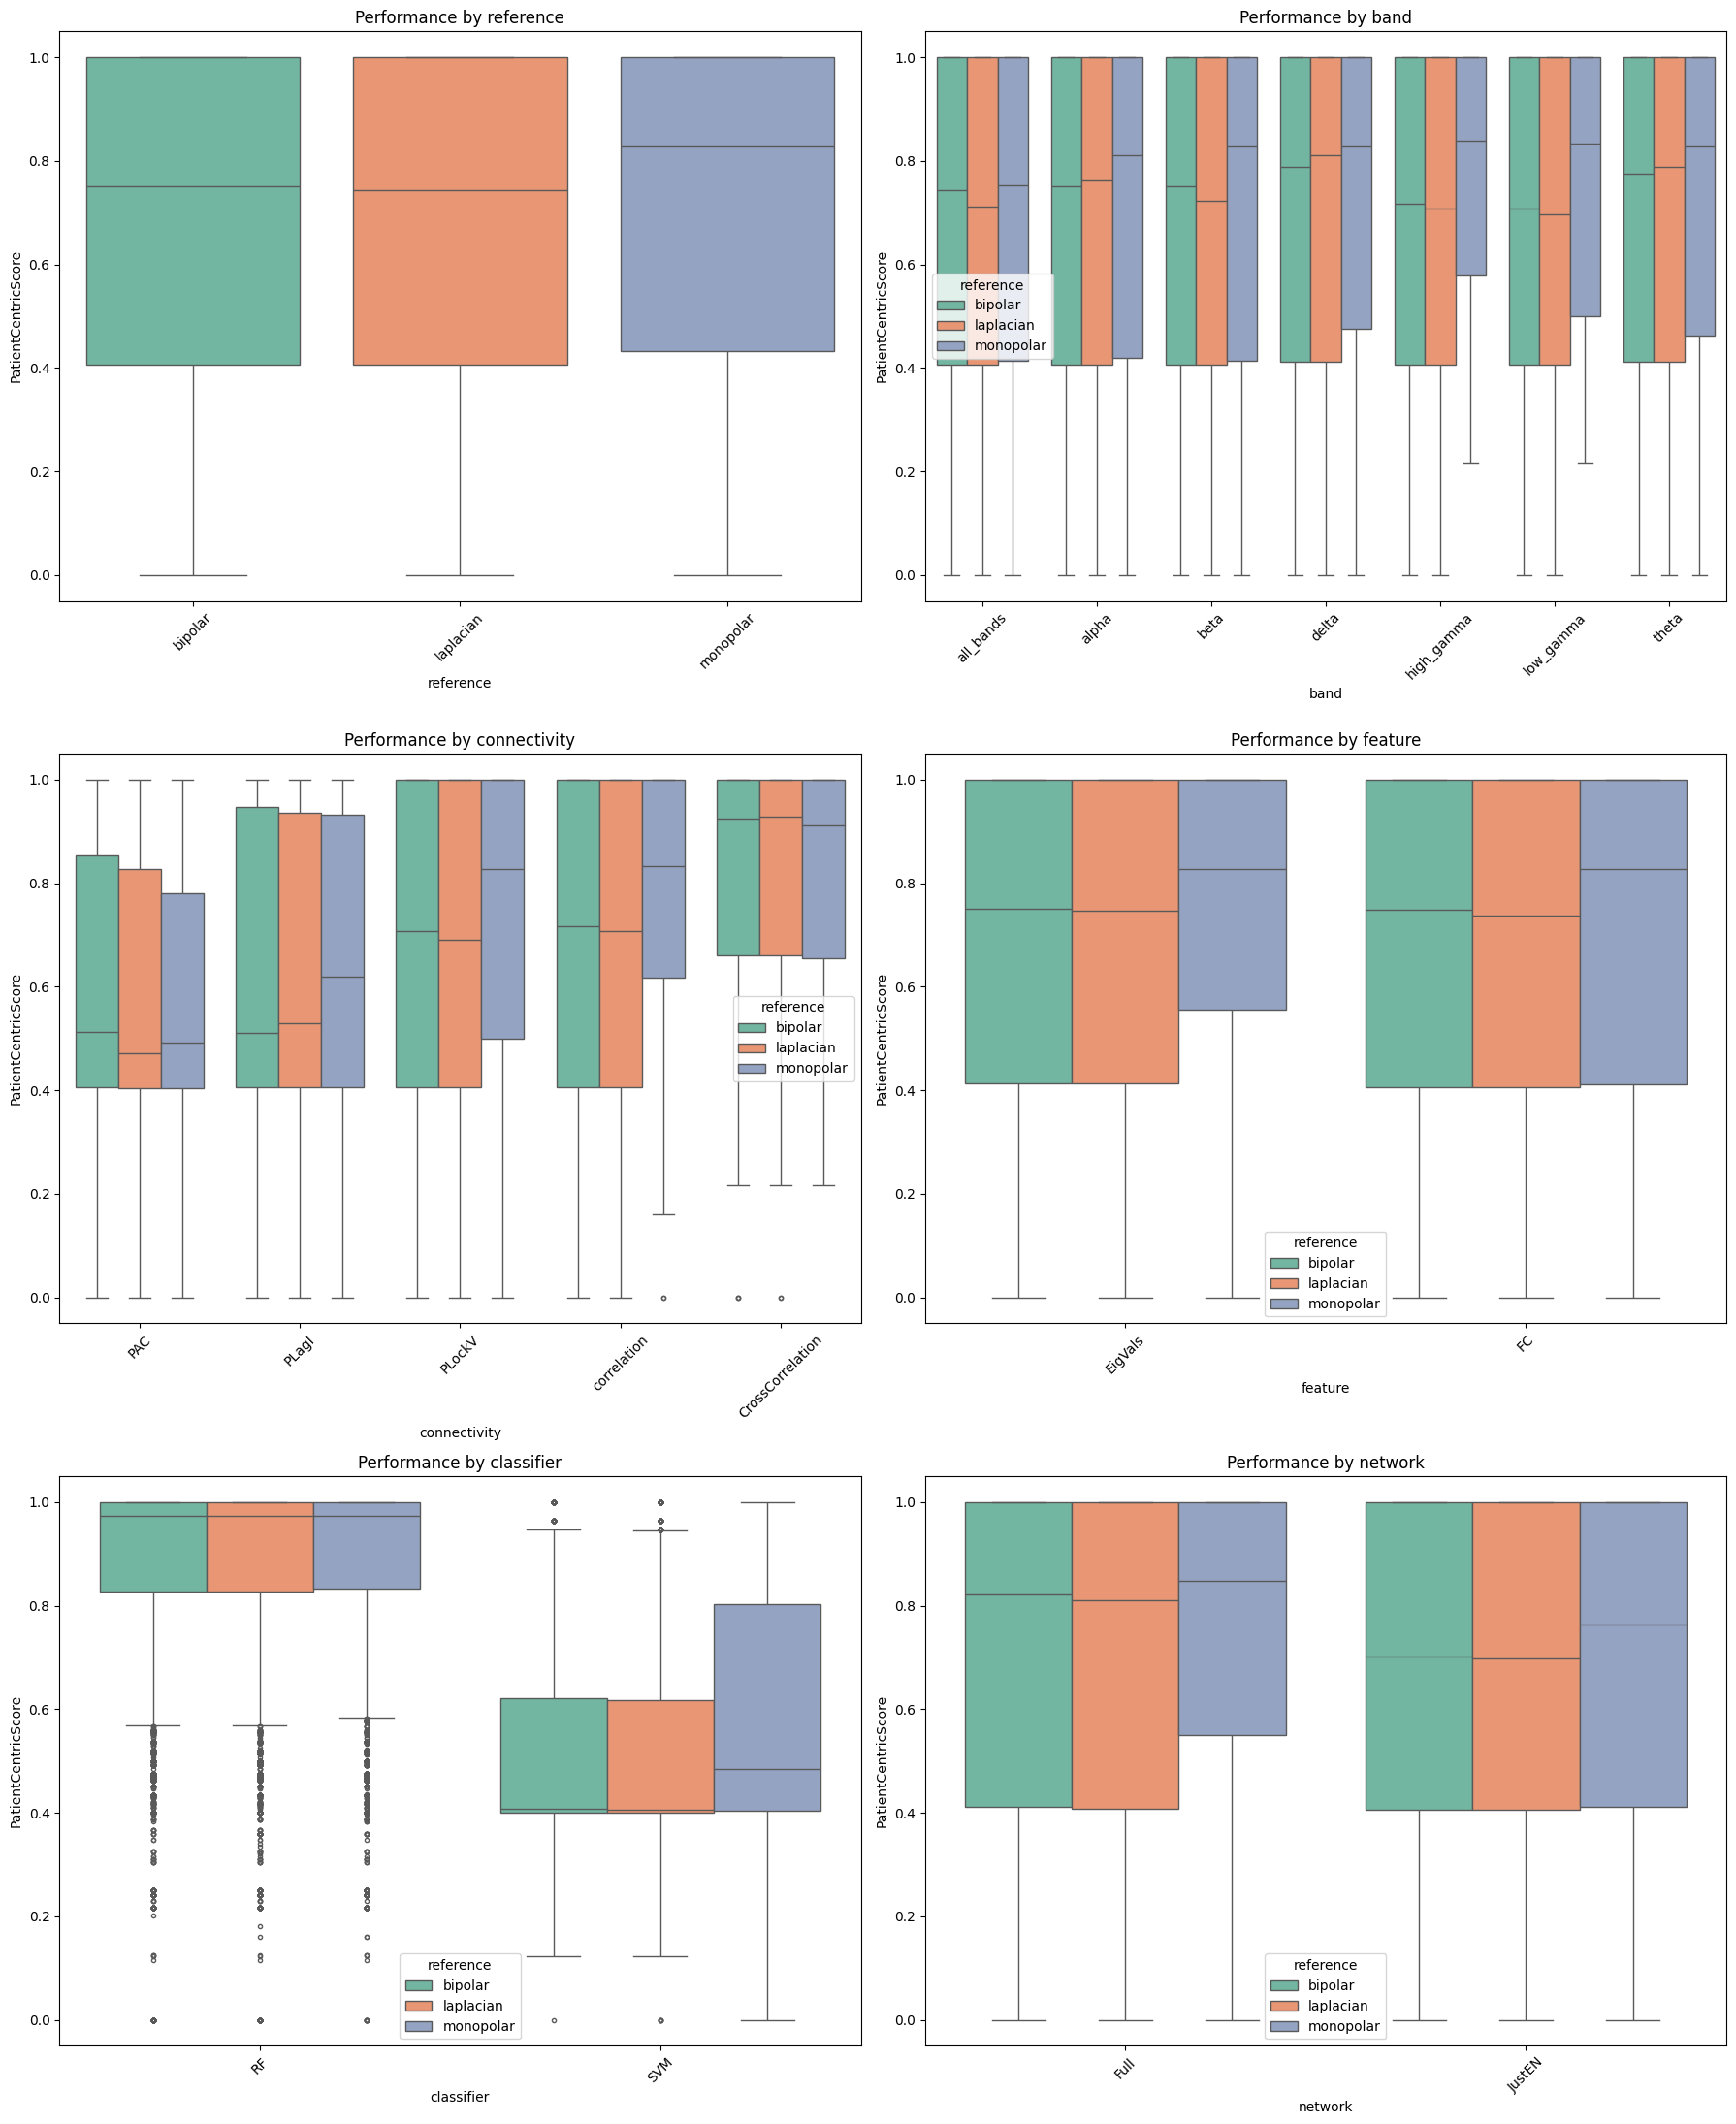

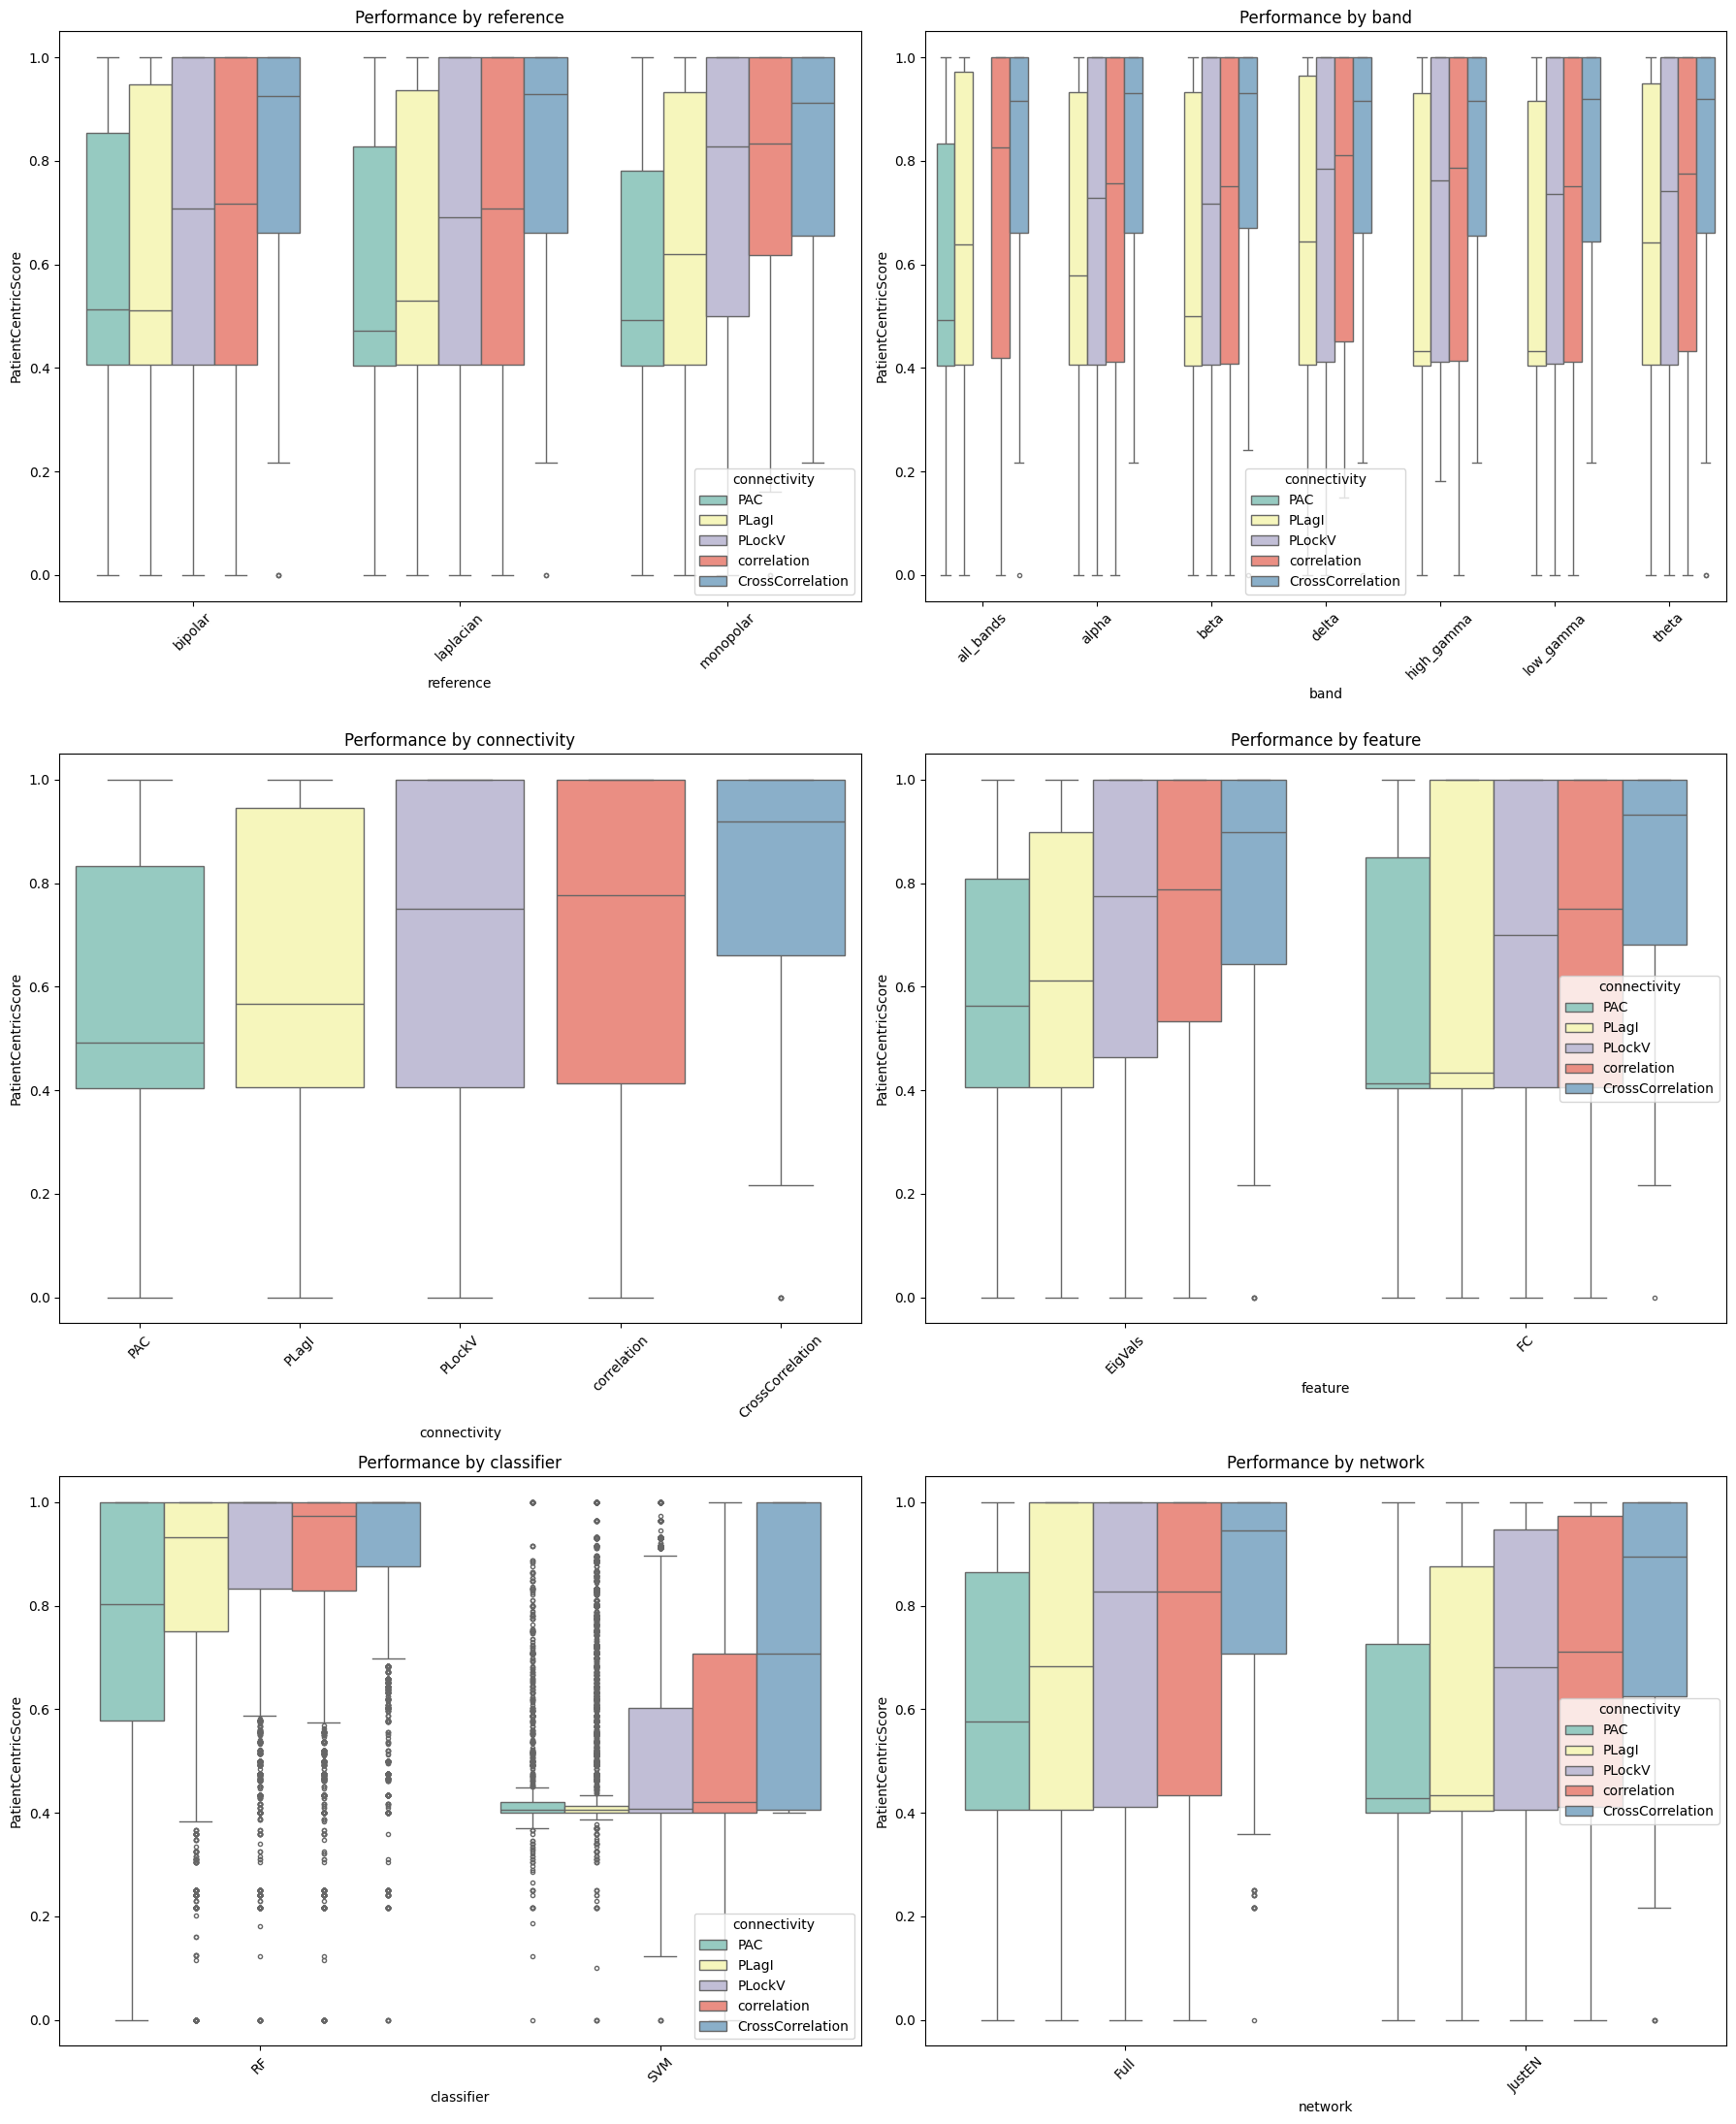

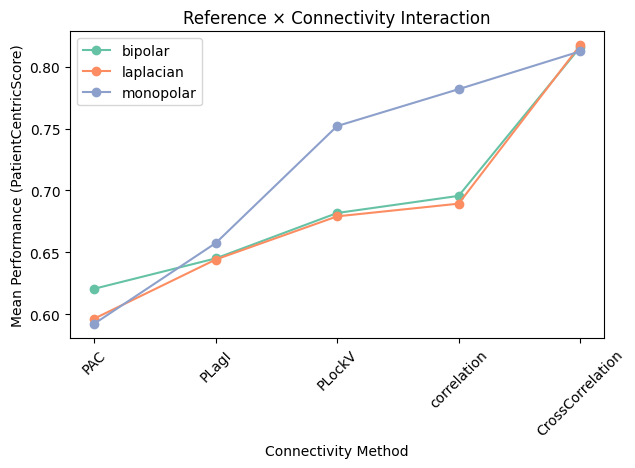

([0, 1, 2, 3, 4],
 [Text(0, 0, 'PAC'),
  Text(1, 0, 'PLagI'),
  Text(2, 0, 'PLockV'),
  Text(3, 0, 'correlation'),
  Text(4, 0, 'CrossCorrelation')])

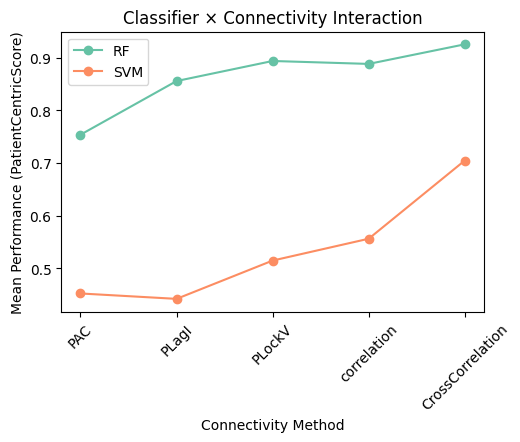

In [293]:
plt.figure(figsize=(18, 22))

# Box plots for main effects with custom outlier marker
n_factors = len(factors)
n_rows = 3
n_cols = 2
for i, factor in enumerate(factors, 1):
    plt.subplot(n_rows, n_cols, i)
    connectivity_means = results_wide.groupby('connectivity')[metric].mean().sort_values()
    connectivity_order = connectivity_means.index.tolist()
    if factor == 'connectivity':
        sns.boxplot(
            data=results_wide,
            x=factor,
            order=connectivity_order,
            y=metric,
            hue='reference',
            palette='Set2',
            hue_order=results_wide['reference'].cat.categories,
            flierprops=dict(marker='.', markersize=6, linestyle='none')
        )
    else:
        sns.boxplot(
            data=results_wide,
            x=factor,
            y=metric,
            hue='reference',
            palette='Set2',
            flierprops=dict(marker='.', markersize=6, linestyle='none')
        )
    plt.title(f'Performance by {factor}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 22))
# Box plots for main effects with connectivity hue ordered by mean value
n_factors = len(factors)
n_rows = 3
n_cols = 2
for i, factor in enumerate(factors, 1):
    plt.subplot(n_rows, n_cols, i)
    # Compute mean metric for each connectivity
    connectivity_means = results_wide.groupby('connectivity')[metric].mean().sort_values()
    connectivity_order = connectivity_means.index.tolist()
    if factor == 'connectivity':
        sns.boxplot(
            data=results_wide,
            x=factor,
            order=connectivity_order,
            y=metric,
            hue='connectivity',
            palette='Set3',
            hue_order=connectivity_order,
            flierprops=dict(marker='.', markersize=6, linestyle='none')
        )
    else:
        sns.boxplot(
            data=results_wide,
            x=factor,
            y=metric,
            hue='connectivity',
            palette='Set3',
            hue_order=connectivity_order,
            flierprops=dict(marker='.', markersize=6, linestyle='none')
        )
    plt.title(f'Performance by {factor}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2. Interaction plots
plt.figure(figsize=(12, 8))

# Reference × Connectivity interaction
plt.subplot(2, 2, 1)
palette = sns.color_palette('Set2', n_colors=len(results_wide['reference'].cat.categories))
for idx, ref in enumerate(results_wide['reference'].cat.categories):
    ref_data = results_wide[results_wide['reference'] == ref]
    means = ref_data.groupby('connectivity')[metric].mean()
    means = means.sort_values()  # Order by AUROC from lowest to highest
    plt.plot(means.index, means.values, marker='o', label=ref, color=palette[idx])
plt.title('Reference × Connectivity Interaction')
plt.xlabel('Connectivity Method')
plt.ylabel(f'Mean Performance ({metric})')
plt.legend()
plt.xticks(rotation=45)

# Add more interaction plots as needed
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))

# Step 1: Compute mean performance per connectivity method across classifiers
mean_performance = results_wide.groupby('connectivity')[metric].mean()

# Step 2: Sort connectivity methods from lowest to highest mean performance
connectivity_order = mean_performance.sort_values().index

# Step 3: Plot with consistent ordering
plt.subplot(2, 2, 1)
palette = sns.color_palette('Set2', n_colors=len(results_wide['classifier'].cat.categories))

for idx, ref in enumerate(results_wide['classifier'].cat.categories):
    ref_data = results_wide[results_wide['classifier'] == ref]
    means = ref_data.groupby('connectivity')[metric].mean()
    means = means.reindex(connectivity_order)  # Ensure consistent order across classifiers
    plt.plot(means.index, means.values, marker='o', label=ref, color=palette[idx])

plt.title('Classifier × Connectivity Interaction')
plt.xlabel('Connectivity Method')
plt.ylabel(f'Mean Performance ({metric})')
plt.legend()
plt.xticks(rotation=45)


# Strategic Approach for patient-Specific Optimization
## Systematic evaluation

SUBJECT-SPECIFIC METHOD OPTIMIZATION ANALYSIS for  PatientCentricScore
Obtained data for 14 subjects
Total observations: 87360
=== FINDING BEST COMBINATIONS PER SUBJECT ===

Subject BGL:
  Best combination: monopolar-beta-PLockV-FC-RF-Full
  PatientCentricScore: 0.9502 ± 0.0090
  Top 5 combinations:
    0.9502 ± 0.0090 | mon-bet-PLoc-FC-RF-Full
    0.9484 ± 0.0126 | mon-the-PLoc-FC-RF-Full
    0.9480 ± 0.0103 | lap-the-PLoc-FC-RF-Full
    0.9473 ± 0.0105 | lap-all-corr-FC-RF-Full
    0.9464 ± 0.0142 | lap-alp-PLoc-FC-RF-Full

Subject CRD:
  Best combination: bipolar-beta-CrossCorrelation-FC-RF-Full
  PatientCentricScore: 1.0000 ± 0.0000
  Top 5 combinations:
    1.0000 ± 0.0000 | bip-bet-Cros-FC-RF-Full
    1.0000 ± 0.0000 | mon-bet-PLag-FC-RF-Full
    1.0000 ± 0.0000 | lap-alp-PLoc-FC-RF-Full
    1.0000 ± 0.0000 | lap-hig-PLoc-FC-RF-Full
    1.0000 ± 0.0000 | lap-low-Cros-FC-RF-Full

Subject CRF:
  Best combination: monopolar-all_bands-CrossCorrelation-EigVals-RF-Full
  PatientCentric

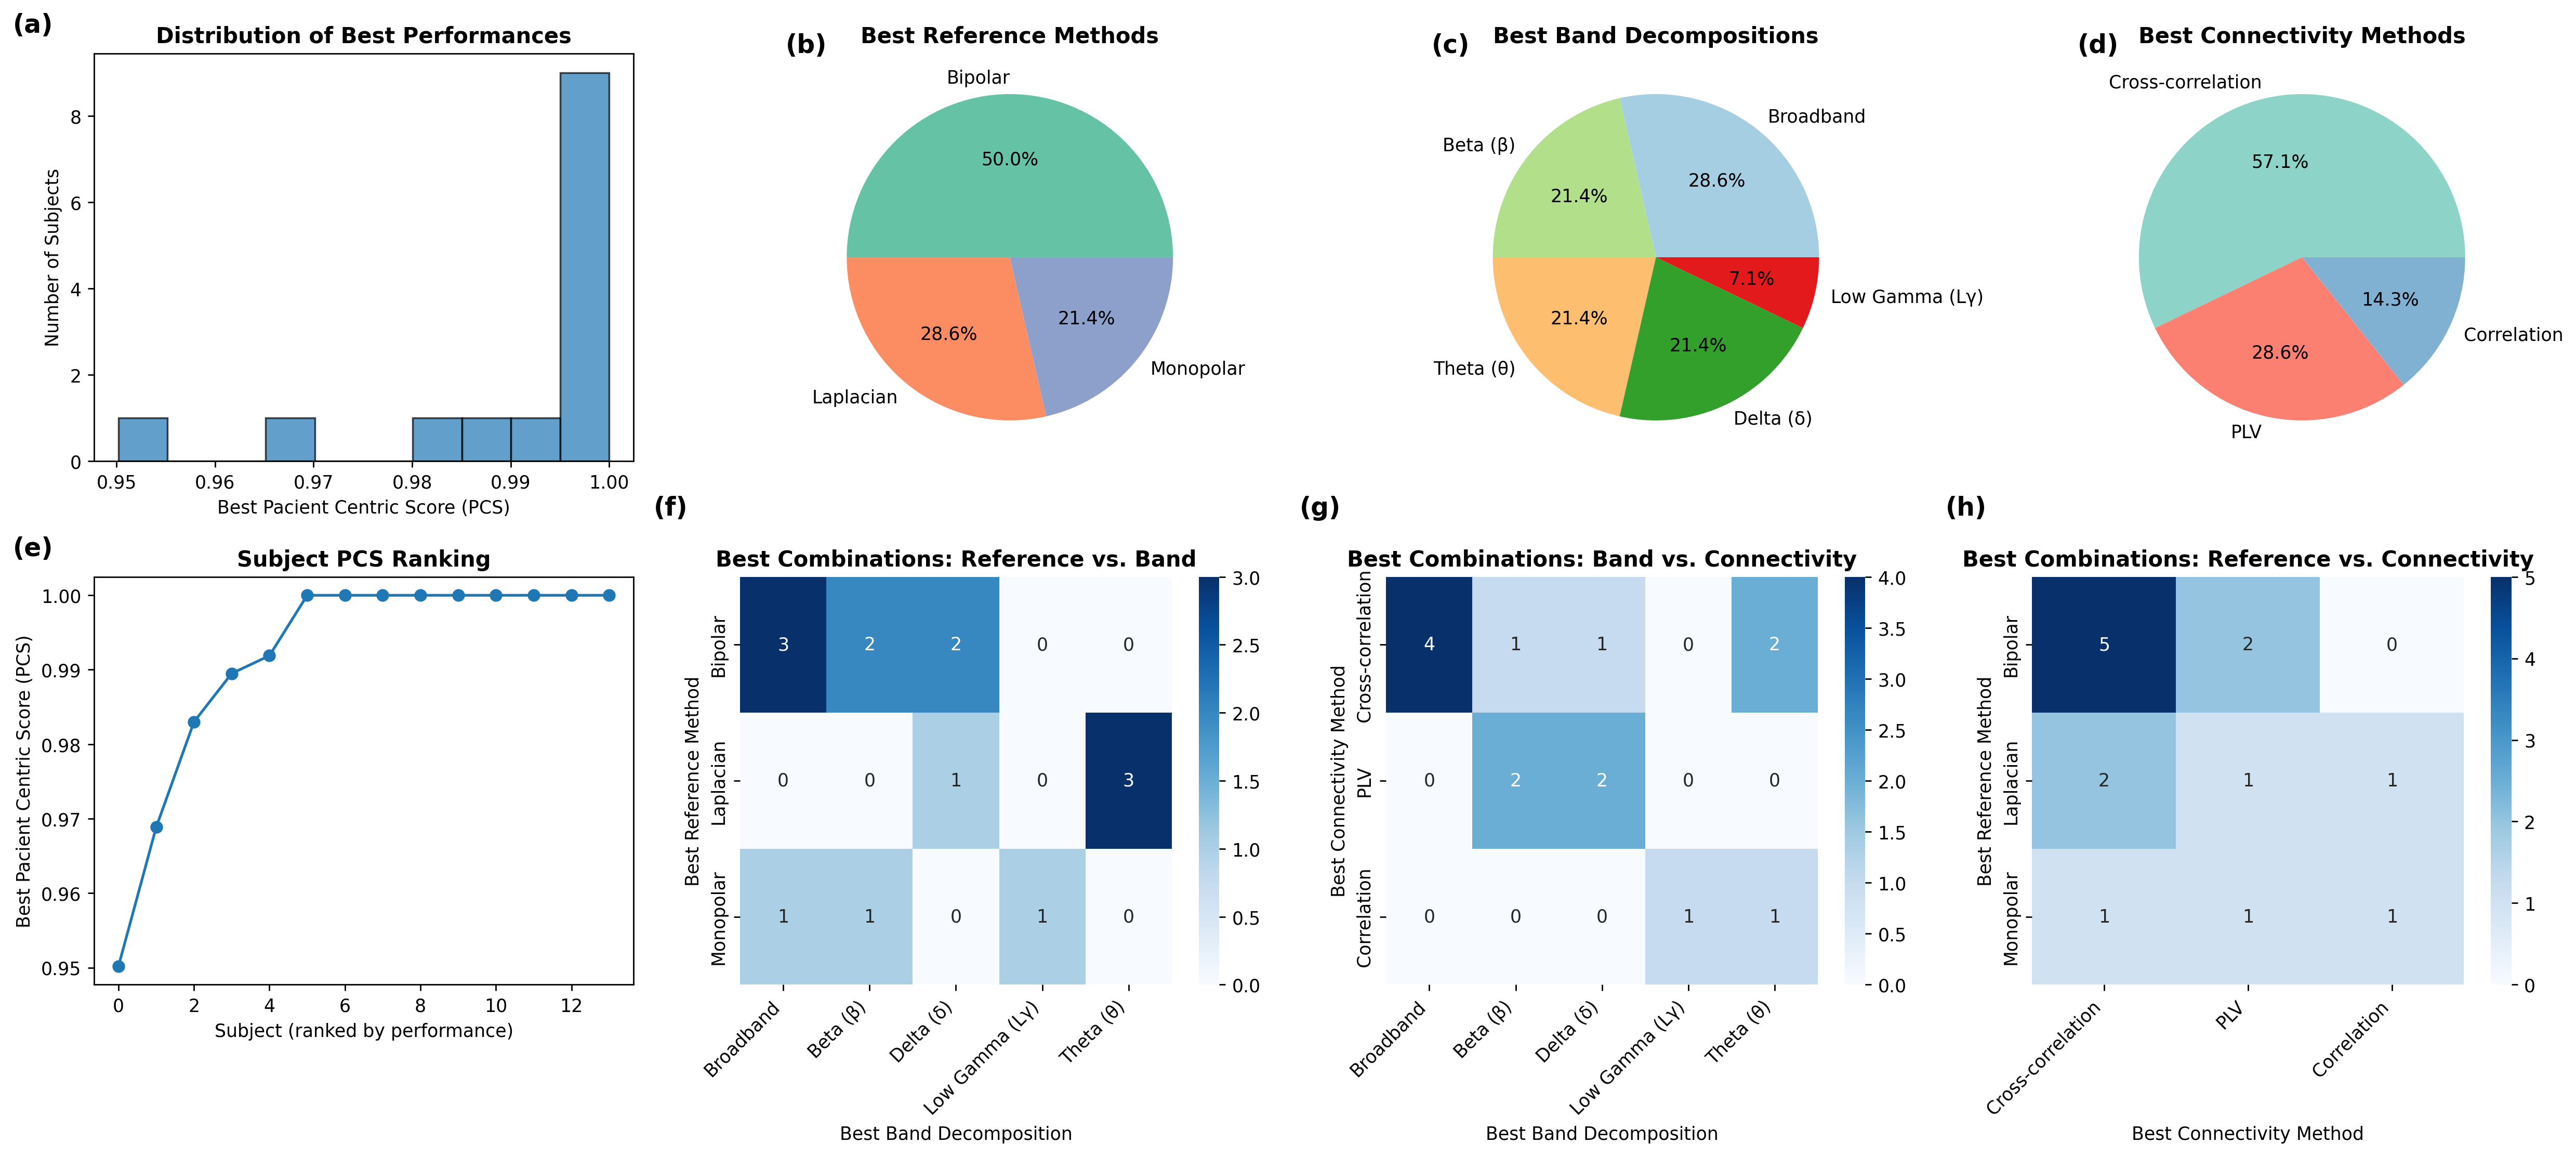

Mean best performance across subjects: 0.9916748008868262, std: 0.015051029804749155
Mean significant differences: 345.57142857142856, std: 146.6193878651769, min: 120, max: 495


OSError: Cannot save file into a non-existent directory: '/Volumes/MyBook/justo/oneMINUTE/metadata/best_classifiers'

In [360]:
import pandas as pd
import numpy as np
from itertools import product
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Ensure 'PLockV' is a valid category in the 'connectivity' column
if 'connectivity' in results_wide.columns and pd.api.types.is_categorical_dtype(results_wide['connectivity']):
    if 'PLockV' not in results_wide['connectivity'].cat.categories:
        results_wide['connectivity'] = results_wide['connectivity'].cat.add_categories(['PLockV'])

# Create a new column 'Combination' as reference-band-connectivity-feature-classifier
results_wide['Combination'] = (
    results_wide['reference'].astype(str) + '-' +
    results_wide['band'].astype(str) + '-' +
    results_wide['connectivity'].astype(str) + '-' +
    results_wide['feature'].astype(str) + '-' +
    results_wide['classifier'].astype(str) + '-' +
    results_wide['network'].astype(str)
)

def find_best_combinations_per_subject(data, metric='PatientCentricScore', top_k=5):
    """
    Find the best combinations for each subject
    """
    print("=== FINDING BEST COMBINATIONS PER SUBJECT ===\n")
    
    results = {}
    
    for subject in data['patient'].unique():
        subject_data = data[data['patient'] == subject]
        
        # Calculate mean performance for each combination
        combo_performance = subject_data.groupby('Combination')[metric].agg(['mean', 'std', 'count']).reset_index()
        combo_performance['se'] = combo_performance['std'] / np.sqrt(combo_performance['count'])
        
        # Sort by mean performance
        combo_performance_sorted = combo_performance.sort_values('mean', ascending=False)
        
        # Get top k combinations
        top_combinations = combo_performance_sorted.head(top_k)
        
        results[subject] = {
            'top_combinations': top_combinations,
            'best_combination': combo_performance_sorted.iloc[0]['Combination'],
            'best_performance': combo_performance_sorted.iloc[0]['mean'],
            'best_se': combo_performance_sorted.iloc[0]['se']
        }
        
        print(f"Subject {subject}:")
        print(f"  Best combination: {results[subject]['best_combination']}")
        print(f"  {metric}: {results[subject]['best_performance']:.4f} ± {results[subject]['best_se']:.4f}")
        print(f"  Top {top_k} combinations:")
        for idx, row in top_combinations.iterrows():
            parts = row['Combination'].split('-')
            print(f"    {row['mean']:.4f} ± {row['se']:.4f} | {parts[0][:3]}-{parts[1][:3]}-{parts[2][:4]}-{parts[3][:4]}-{parts[4]}-{parts[5]}")
        print()
    
    return results

def statistical_significance_testing(data, subject_results, metric='PatientCentricScore', alpha=0.05):
    """
    Test if the best combination is significantly better than others for each subject
    """
    print("=== STATISTICAL SIGNIFICANCE TESTING ===\n")
    
    significance_results = {}
    
    for subject in data['patient'].unique():
        subject_data = data[data['patient'] == subject]
        best_combo = subject_results[subject]['best_combination']
        
        # Get performance values for best combination
        best_values = subject_data[subject_data['Combination'] == best_combo][metric].values
        
        # Test against all other combinations
        other_combos = subject_data[subject_data['Combination'] != best_combo]['Combination'].unique()
        
        significant_differences = []
        
        for other_combo in other_combos[:500]:  # Test against top 100 alternatives to avoid too many tests
            other_values = subject_data[subject_data['Combination'] == other_combo][metric].values
            
            # Use Mann-Whitney U test (robust to non-normal distributions)
            if len(other_values) > 0:
                u_stat, p_value = stats.mannwhitneyu(best_values, other_values, alternative='greater')
                
                if p_value < alpha:
                    significant_differences.append({
                        'comparison': other_combo,
                        'p_value': p_value,
                        'u_statistic': u_stat
                    })
        
        significance_results[subject] = {
            'n_significant': len(significant_differences),
            'significant_comparisons': significant_differences
        }
        
        print(f"Subject {subject}: Best combination significantly better than {len(significant_differences)} others")
    
    return significance_results

def identify_subject_specific_patterns(data, subject_results):
    """
    Identify patterns in what makes combinations optimal for different subjects
    """
    print("\n=== SUBJECT-SPECIFIC PATTERN ANALYSIS ===\n")
    
    # Extract components from best combinations
    best_combinations_df = []
    
    for subject, results in subject_results.items():
        combo = results['best_combination']
        parts = combo.split('-')
        
        best_combinations_df.append({
            'Subject': subject,
            'Best_Reference': parts[0],
            'Best_Band': parts[1],
            'Best_Connectivity': parts[2],
            'Best_Feature': parts[3],
            'Best_Classifier': parts[4],
            'Best_Network': parts[5],
            'Best_Performance': results['best_performance']
        })
    
    best_df = pd.DataFrame(best_combinations_df)
    
    # Analyze frequency of each component in best combinations
    print("FREQUENCY OF COMPONENTS IN BEST COMBINATIONS:")
    print("-" * 50)
    
    components = ['Best_Reference', 'Best_Band', 'Best_Connectivity', 'Best_Feature', 'Best_Classifier', 'Best_Network']
    
    for component in components:
        freq = best_df[component].value_counts()
        print(f"\n{component.replace('Best_', '')}:")
        for method, count in freq.items():
            percentage = (count / len(best_df)) * 100
            print(f"  {method}: {count}/{len(best_df)} ({percentage:.1f}%)")
    
    return best_df

def personalized_recommendation_system(data, subject_results, metric='PatientCentricScore', new_subject_data=None):
    """
    Create a recommendation system for new subjects based on patterns
    """
    print("\n=== PERSONALIZED RECOMMENDATION SYSTEM ===\n")
    
    # Extract features that predict good performance
    best_df = []
    
    for subject, results in subject_results.items():
        combo = results['best_combination']
        parts = combo.split('-')
        
        best_df.append({
            'Subject': subject,
            'Reference': parts[0],
            'Band': parts[1],
            'Connectivity': parts[2],
            'Feature': parts[3],
            'Classifier': parts[4],
            'Network': parts[5],
            f'{metric}': results['best_performance']
        })
    
    best_df = pd.DataFrame(best_df)
    
    # Create a simple recommendation based on most frequent best choices
    recommendations = {}
    
    for component in ['Reference', 'Band', 'Connectivity', 'Feature', 'Classifier', 'Network']:
        most_common = best_df[component].mode()[0]
        recommendations[component] = most_common
    
    recommended_combo = f"{recommendations['Reference']}_{recommendations['Band']}_{recommendations['Connectivity']}_{recommendations['Feature']}_{recommendations['Classifier']}_{recommendations['Network']}"
    
    print("GENERAL RECOMMENDATIONS FOR NEW SUBJECTS:")
    print("-" * 45)
    for component, method in recommendations.items():
        print(f"{component}: {method}")
    
    print(f"\nRecommended starting combination: {recommended_combo}")
    
    return recommendations

def multi_objective_optimization(data, metric='PatientCentricScore', weights=None):

    global combo_metrics

    print("\n=== MULTI-OBJECTIVE OPTIMIZATION ===\n")
    
    results = {}
    
    for subject in data['patient'].unique():
        subject_data = data[data['patient'] == subject]
        
        # Calculate metrics for each combination
        combo_metrics = subject_data.groupby('Combination').agg({
            f'{metric}': ['mean', 'std']
        }).reset_index()
        
        combo_metrics.columns = ['Combination', 'Mean_Performance', 'Std_Performance']
        
        # Calculate composite score (example: maximize performance, minimize variance)
        combo_metrics['Stability'] = 1 / (1 + combo_metrics['Std_Performance'])  # Higher = more stable
        combo_metrics['Composite_Score'] = (
            weights[0] * combo_metrics['Mean_Performance'] + 
            (weights[1] if len(weights) > 1 else 0.2) * combo_metrics['Stability']
        )
        
        # Find best combination based on composite score
        best_idx = combo_metrics['Composite_Score'].idxmax()
        best_combo = combo_metrics.loc[best_idx]
        
        results[subject] = {
            'best_combination': best_combo['Combination'],
            'performance': best_combo['Mean_Performance'],
            'stability': best_combo['Stability'],
            'composite_score': best_combo['Composite_Score']
        }
        
        print(f"Subject {subject}:")
        print(f"  Best combination: {best_combo['Combination']}")
        print(f"  Performance: {best_combo['Mean_Performance']:.4f}")
        print(f"  Stability: {best_combo['Stability']:.4f}")
        print(f"  Composite Score: {best_combo['Composite_Score']:.4f}")
        print()
    
    return results

def cross_subject_validation(data, subject_results, metric='PatientCentricScore'):
    """
    Validate if patterns found in some subjects generalize to others
    """
    print("=== CROSS-SUBJECT VALIDATION ===\n")
    
    subjects = list(data['patient'].unique())
    n_subjects = len(subjects)
    
    # Leave-one-subject-out validation
    generalization_scores = []
    
    for test_subject in subjects:
        # Train on all other subjects
        train_subjects = [s for s in subjects if s != test_subject]
        
        # Find most common best methods from training subjects
        train_best_combinations = [subject_results[s]['best_combination'] for s in train_subjects]
        
        # Extract components
        train_components = {'Reference': [], 'Band': [], 'Connectivity': [], 'Feature': [], 'Classifier': [], 'Network': []}
        
        for combo in train_best_combinations:
            parts = combo.split('-')
            train_components['Reference'].append(parts[0])
            train_components['Band'].append(parts[1])
            train_components['Connectivity'].append(parts[2])
            train_components['Feature'].append(parts[3])
            train_components['Classifier'].append(parts[4])
            train_components['Network'].append(parts[5])
        
        # Find most common choice for each component
        recommended = {}
        for component, choices in train_components.items():
            recommended[component] = max(set(choices), key=choices.count)
        
        recommended_combo = f"{recommended['Reference']}_{recommended['Band']}_{recommended['Connectivity']}_{recommended['Feature']}_{recommended['Classifier']}_{recommended['Network']}"
        
        # Test on held-out subject
        test_subject_data = data[data['patient'] == test_subject]
        
        if recommended_combo in test_subject_data['Combination'].values:
            recommended_performance = test_subject_data[
                test_subject_data['Combination'] == recommended_combo
            ][metric].mean()
            
            actual_best_performance = subject_results[test_subject]['best_performance']
            
            # Calculate how close the recommendation is to the actual best
            generalization_score = recommended_performance / actual_best_performance
            generalization_scores.append(generalization_score)
            
            print(f"Subject {test_subject}: Recommended performance = {recommended_performance:.4f}, "
                  f"Best possible = {actual_best_performance:.4f}, "
                  f"Ratio = {generalization_score:.4f}")
    
    mean_generalization = np.mean(generalization_scores)
    print(f"\nMean generalization score: {mean_generalization:.4f}")
    print(f"Standard deviation: {np.std(generalization_scores):.4f}")
    
    return generalization_scores

def create_subject_optimization_visualizations(data, subject_results, best_patterns_df, metric='PatientCentricScore'):
    """
    Create visualizations for subject-specific optimization results
    """
    print("\n=== CREATING VISUALIZATIONS ===\n")
    
    # 1. distribution across subjects
    plt.figure(figsize=(20, 9), dpi=250)
    subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

    # Best performance per subject
    plt.subplot(2, 4, 1)
    best_performances = [results['best_performance'] for results in subject_results.values()]
    plt.hist(best_performances, bins=10, alpha=0.7, edgecolor='black')
    plt.xlabel(f'Best Pacient Centric Score (PCS)')
    plt.ylabel('Number of Subjects')
    plt.title('Distribution of Best Performances', fontweight='bold')
    plt.text(-0.15, 1.1, subplot_labels[0], transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # Component frequency in best combinations REFERENCE
    plt.subplot(2, 4, 2)
    reference_counts = best_patterns_df['Best_Reference'].value_counts()
    reference_labels = [label.capitalize() for label in reference_counts.index]
    all_references = ['bipolar', 'laplacian', 'monopolar']
    set2_colors = sns.color_palette('Set2', n_colors=len(all_references))
    color_map = dict(zip(all_references, set2_colors))
    pie_colors = [color_map[label] for label in reference_counts.index]
    plt.pie(reference_counts.values, labels=reference_labels, autopct='%1.1f%%', colors=pie_colors)
    plt.title('Best Reference Methods', fontweight='bold')
    plt.text(-0.05, 1.05, subplot_labels[1], transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # Component frequency in best combinations BAND
    plt.subplot(2, 4, 3)
    band_counts = best_patterns_df['Best_Band'].value_counts()
    band_labels = list(band_counts.index)
    all_bands = sorted(results_wide['band'].unique())
    set3_colors = sns.color_palette('Paired', n_colors=len(all_bands))
    color_map = dict(zip(all_bands, set3_colors))

    greek_map = {
        'alpha': 'α',
        'beta': 'β',
        'delta': 'δ',
        'theta': 'θ',
        'low gamma': 'Lγ',
        'high gamma': 'Hγ'
    }

    def prettify_band_label(label):
        label_mod = label.replace('_', ' ')
        if label_mod.strip().lower() == 'all bands':
            return 'Broadband'
        label_mod = ' '.join([w.capitalize() for w in label_mod.split()])
        for k, v in greek_map.items():
            if k in label_mod.lower():
                return f"{label_mod} ({v})"
        return label_mod

    pie_labels = [prettify_band_label(l) for l in band_labels]
    pie_colors = [color_map[label] for label in band_labels]
    plt.pie(band_counts.values, labels=pie_labels, autopct='%1.1f%%', colors=pie_colors)
    plt.title('Best Band Decompositions', fontweight='bold')
    plt.text(-0.05, 1.05, subplot_labels[2], transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # Component frequency in best combinations CONNECTIVITY
    plt.subplot(2, 4, 4)
    connectivity_counts = best_patterns_df['Best_Connectivity'].value_counts()
    connectivity_labels = list(connectivity_counts.index)
    all_connectivities = sorted(results_wide['connectivity'].unique())
    set3_colors = sns.color_palette('Set3', n_colors=len(all_connectivities))
    color_map = dict(zip(all_connectivities, set3_colors))

    def prettify_connectivity_label(label):
        if label == 'CrossCorrelation':
            return 'Cross-correlation'
        elif label == 'PLockV':
            return 'PLV'
        elif label == 'correlation':
            return 'Correlation'
        else:
            return label

    pie_labels = [prettify_connectivity_label(l) for l in connectivity_labels]
    pie_colors = [color_map[label] for label in connectivity_labels]
    plt.pie(connectivity_counts.values, labels=pie_labels, autopct='%1.1f%%', colors=pie_colors)
    plt.title('Best Connectivity Methods', fontweight='bold')
    plt.text(-0.05, 1.05, subplot_labels[3], transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # AUROC vs subject (ordered by performance)
    plt.subplot(2, 4, 5)
    subjects = list(subject_results.keys())
    performances = [subject_results[s]['best_performance'] for s in subjects]
    sorted_indices = np.argsort(performances)
    plt.plot(range(len(subjects)), [performances[i] for i in sorted_indices], 'o-')
    plt.xlabel('Subject (ranked by performance)')
    plt.ylabel(f'Best Pacient Centric Score (PCS)')
    plt.title(f'Subject PCS Ranking', fontweight='bold')
    plt.text(-0.15, 1.1, subplot_labels[4], transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # Helper functions for prettifying labels
    def prettify_band_label(label):
        greek_map = {
            'alpha': 'α',
            'beta': 'β',
            'delta': 'δ',
            'theta': 'θ',
            'low gamma': 'Lγ',
            'high gamma': 'Hγ'
        }
        if label == 'all_bands':
            return 'Broadband'
        label_mod = label.replace('_', ' ')
        for k, v in greek_map.items():
            if k in label_mod.lower():
                pretty = ' '.join([w.capitalize() for w in label_mod.split()])
                return f"{pretty} ({v})"
        return ' '.join([w.capitalize() for w in label_mod.split()])

    def prettify_connectivity_label(label):
        if label == 'CrossCorrelation':
            return 'Cross-correlation'
        elif label == 'PLockV':
            return 'PLV'
        else:
            return ' '.join([w.capitalize() for w in label.replace('_', ' ').split()])

    def prettify_reference_label(label):
        return ' '.join([w.capitalize() for w in label.replace('_', ' ').split()])

    # Heatmap of method combinations REF X BAND
    plt.subplot(2, 4, 6)
    heatmap_data = best_patterns_df.groupby(['Best_Reference', 'Best_Band']).size().unstack(fill_value=0)
    if not heatmap_data.empty:
        heatmap_data.index = [prettify_reference_label(idx) for idx in heatmap_data.index]
        heatmap_data.columns = [prettify_band_label(col) for col in heatmap_data.columns]
        ax = sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
        plt.title('Best Combinations: Reference vs. Band', fontweight='bold')
        plt.xlabel('Best Band Decomposition')
        plt.ylabel('Best Reference Method')
        plt.xticks(rotation=45, ha='right')
    plt.text(-0.2, 1.2, subplot_labels[5], transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    plt.tight_layout()

    # Heatmap of method combinations CONNECTIVITY X BAND
    plt.subplot(2, 4, 7)
    heatmap_data = best_patterns_df.groupby(['Best_Connectivity', 'Best_Band']).size().unstack(fill_value=0)
    if not heatmap_data.empty:
        heatmap_data.index = [prettify_connectivity_label(idx) for idx in heatmap_data.index]
        heatmap_data.columns = [prettify_band_label(col) for col in heatmap_data.columns]
        ax = sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
        plt.title('Best Combinations: Band vs. Connectivity', fontweight='bold')
        plt.xlabel('Best Band Decomposition')
        plt.ylabel('Best Connectivity Method')
        plt.xticks(rotation=45, ha='right')
    plt.text(-0.2, 1.2, subplot_labels[6], transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    plt.tight_layout()

    # Heatmap of method combinations REF X CONNECTIVITY
    plt.subplot(2, 4, 8)
    heatmap_data = best_patterns_df.groupby(['Best_Reference', 'Best_Connectivity']).size().unstack(fill_value=0)
    if not heatmap_data.empty:
        heatmap_data.index = [prettify_reference_label(idx) for idx in heatmap_data.index]
        heatmap_data.columns = [prettify_connectivity_label(col) for col in heatmap_data.columns]
        ax = sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
        plt.title('Best Combinations: Reference vs. Connectivity', fontweight='bold')
        plt.xlabel('Best Connectivity Method')
        plt.ylabel('Best Reference Method')
        plt.xticks(rotation=45, ha='right')
    plt.text(-0.2, 1.2, subplot_labels[7], transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    plt.tight_layout()
    plt.show()

# Main analysis function
def run_subject_optimization_analysis():
    """
    Run complete subject-specific optimization analysis
    """

    metrics = ['PatientCentricScore']

    for metric in metrics:

        print("SUBJECT-SPECIFIC METHOD OPTIMIZATION ANALYSIS for ", metric)
        print("=" * 60)
        
        # Generate subject data
        data = results_wide.__deepcopy__()
        print(f"Obtained data for {data['patient'].nunique()} subjects")
        print(f"Total observations: {len(data)}")
        
        # Find best combinations per subject
        subject_results = find_best_combinations_per_subject(data, metric=metric, top_k=5)
        
        # Statistical significance testing
        significance_results = statistical_significance_testing(data, subject_results, metric=metric)
        
        # Identify patterns
        best_patterns_df = identify_subject_specific_patterns(data, subject_results)
        
        # Multi-objective optimization
        multi_obj_results = multi_objective_optimization(data, metric='PatientCentricScore', weights=[0.8, 0.2])
        
        # Personalized recommendations
        recommendations = personalized_recommendation_system(data, subject_results, metric=metric)
        
        # Cross-subject validation
        generalization_scores = cross_subject_validation(data, subject_results, metric=metric)
        
        # Create visualizations
        create_subject_optimization_visualizations(data, subject_results, best_patterns_df, metric=metric)
    
    return data, subject_results, best_patterns_df, recommendations, significance_results

data, subject_results, patterns, recommendations, significance_results = run_subject_optimization_analysis()

# Save results to CSV files
subject_results_df = pd.DataFrame.from_dict(subject_results, orient='index')

subject_results_df.best_performance
print(f'Mean best performance across subjects: {subject_results_df.best_performance.mean()}, std: {subject_results_df.best_performance.std()}')

# Aggregate n_significant across all subjects
n_significant_list = [v['n_significant'] for v in significance_results.values()]
print(f"Mean significant differences: {np.mean(n_significant_list)}, std: {np.std(n_significant_list)}, min: {np.min(n_significant_list)}, max: {np.max(n_significant_list)}")

subject_results_df.to_csv('/Volumes/MyBook/justo/oneMINUTE/metadata/best_classifiers/subject_optimization_results.csv', index=True)

In [325]:
subject_results.best_performance.mean()

AttributeError: 'dict' object has no attribute 'best_performance'

In [ ]:
# # PLOT FC
# for classification_metric in classification_metrics:
#     for classification_method in classification_methods:
        
#         if classification_method == 'FC':
#             color = 'Blues_d'
#         elif classification_method == 'EigVals':
#             color = 'Oranges_d'
#         elif 'Dummy' in classification_method:
#             color = 'Purples_d'
        
#         accuracy_results_FC = results[(results.metric==classification_metric) & (results.classification_method==classification_method)]
        
#         mean_values = results[(results.metric == classification_metric) & (results.classification_method == classification_method)].groupby('FC_method')['value'].mean()
        
#         sorted_FC_methods = mean_values.sort_values(ascending=False).index
        
#         accuracy_results_FC_sorted = accuracy_results_FC[accuracy_results_FC['FC_method'].isin(sorted_FC_methods)]
        
        # plt.figure(figsize=(200, 10), dpi=200)
        # sns.boxplot(data=accuracy_results_FC_sorted, x="FC_method", y="value", order=sorted_FC_methods)
        # plt.hlines(0.5, -1, len(accuracy_results_FC_sorted.FC_method.unique()), color='red')
        # plt.xticks(rotation=70, fontsize = 15, rotation_mode='anchor', ha='right', va='center')
        # plt.title(classification_metric+' '+classification_method, fontsize = 25)
        # plt.xlabel('Funtional Connectivity method', fontsize = 25)
        # plt.ylabel('',fontsize = 0)
        # plt.yticks(fontsize=25)
        # plt.ylim(0,1)
        # plt.xlim(-1,len(accuracy_results_FC_sorted.FC_method.unique()))
        # plt.show()

In [ ]:
#Ranking of methods

temp_scores = []
temp_f1_scores = []
temp_accuracies = []
temp_precisions = []
temp_recall = []
temp_AUROC = []

for classification_method in classification_methods:
    for re_reference_method in re_reference_methods:
    
        mean_accuracy_values = results[(results.metric == 'accuracy')&(results.classification_method==classification_method)&(results.reference==re_reference_method)].groupby('FC_method')['value'].mean()
        mean_precision_inter_values = results[(results.metric == 'precision_interictal')&(results.classification_method==classification_method)&(results.reference==re_reference_method)].groupby('FC_method')['value'].mean()
        mean_recall_pre_values = results[(results.metric == 'recall_preictal')&(results.classification_method==classification_method)&(results.reference==re_reference_method)].groupby('FC_method')['value'].mean()
        
        mean_precision_pre_values = results[(results.metric == 'precision_preictal')&(results.classification_method==classification_method)&(results.reference==re_reference_method)].groupby('FC_method')['value'].mean()
        mean_recall_inter_values = results[(results.metric == 'recall_interictal')&(results.classification_method==classification_method)&(results.reference==re_reference_method)].groupby('FC_method')['value'].mean()

        mean_AUROC_values = results[(results.metric == 'AUROC')&(results.classification_method==classification_method)&(results.reference==re_reference_method)].groupby('FC_method')['value'].mean()
        
        score = 3*(mean_accuracy_values) + 2.5*(mean_precision_inter_values + mean_recall_pre_values) + mean_precision_pre_values + mean_recall_inter_values
        f1_score = 2 * (mean_precision_pre_values * mean_recall_pre_values) / (mean_precision_pre_values + mean_recall_pre_values).replace(0, np.nan)
        f1_score = f1_score.fillna(0)

        score.index = [s + '-' + classification_method + '-' + re_reference_method for s in score.index]
        temp_scores.append(score)
        f1_score.index = [s + '-' + classification_method + '-' + re_reference_method for s in f1_score.index]
        temp_f1_scores.append(f1_score)

        mean_accuracy_values.index = [s + '-' + classification_method + '-' + re_reference_method for s in mean_accuracy_values.index]
        temp_accuracies.append(mean_accuracy_values)
        mean_precision_inter_values.index = [s + '-' + classification_method + '-' + re_reference_method for s in mean_precision_inter_values.index]
        temp_precisions.append(mean_precision_inter_values)
        mean_recall_pre_values.index = [s + '-' + classification_method + '-' + re_reference_method for s in mean_recall_pre_values.index]
        temp_recall.append(mean_recall_pre_values)

        mean_AUROC_values.index = [s + '-' + classification_method+ '-' + re_reference_method for s in mean_AUROC_values.index]
        temp_AUROC.append(mean_AUROC_values)
   

scores = pd.concat(temp_scores)
sorted_scores = scores.sort_values(ascending=False).reset_index().rename(columns={"index": "FC_method"})

f1_scores = pd.concat(temp_f1_scores)
sorted_f1_scores = f1_scores.sort_values(ascending=False).reset_index().rename(columns={"index": "FC_method"})

AUROCs = pd.concat(temp_AUROC)
sorted_AUROCs = AUROCs.sort_values(ascending=False).reset_index().rename(columns={"index": "FC_method"})


In [ ]:
# Top F1 scores
top10 = np.array(sorted_f1_scores.FC_method[0:15])
temp_top10 = []
for top in top10:
    FC_method, classification_method, re_reference_method = top.split('-')
    current_dict = results[(results.FC_method == FC_method) & (results.classification_method == classification_method)& (results.reference == re_reference_method)]
    current_dict.FC_method = [s + '-' + classification_method + '-' + re_reference_method for s in current_dict.FC_method]
    current_dict = current_dict[(current_dict.metric!='precision_preictal')&(current_dict.metric!='recall_interictal')&(current_dict.metric!='fpr')&(current_dict.metric!='tpr')]
    temp_top10.append(current_dict)

top10df = pd.concat(temp_top10)

plt.figure(figsize=(20, 10), dpi=200)
# Add alternating background colors
for i in range(len(top10df['FC_method'].unique())):
    color = 'lightgrey' if i % 2 == 0 else 'white'
    plt.axvspan(i - 0.5, i + 0.5, facecolor=color, alpha=0.5)
sns.boxplot(data=top10df, x="FC_method", y="value", hue='metric')
plt.xticks(rotation=70, fontsize = 20, rotation_mode='anchor', ha='right', va='center')
plt.title('Top 15 methods (F1 score-based) performance', fontsize = 30)
plt.xlabel('Funtional Connectivity and classification method', fontsize = 25)
plt.ylabel('Metric value',fontsize = 25)
plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='accuracy')].value.mean(), -1, 15, color='blue', linestyles='dashed', label='Dummy accuracy')
plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='recall_preictal')].value.mean(), -1, 15, color='orange', linestyles='dashed', label='Dummy recall')
plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='precision_interictal')].value.mean(), -1, 15, color='green', linestyles='dashed', label='Dummy precision')
plt.yticks(fontsize=25)
plt.legend(fontsize=18)
plt.xlim(-0.5,14.5)
plt.ylim(0,1)
plt.show()

print(sorted_f1_scores[0:15])

In [ ]:
# Top AUROC scores
top10 = np.append(np.array(sorted_AUROCs.FC_method[0:15]), ['Dummy-stratified', 'Dummy-all_interictal', 'Dummy-all_preictal'])
temp_top10 = []
for top in top10:
    FC_method, classification_method = top.split('-')
    current_dict = results[(results.FC_method == FC_method) & (results.classification_method == classification_method)]
    current_dict.FC_method = [s + '-' + classification_method for s in current_dict.FC_method]
    current_dict = current_dict[(current_dict.metric!='precision_preictal')&(current_dict.metric!='recall_interictal')]
    temp_top10.append(current_dict)

top10df = pd.concat(temp_top10)

# Plot AUROC plots of the top methods
# Convert the 'tpr' and 'fpr' columns from strings to lists of numerical values if they exist
import ast

# Convert the 'value' column from strings to lists of numerical values where the metric is 'tpr' or 'fpr'
# Ensure that the 'value' column is properly handled if it contains NumPy arrays
# Ensure that the 'value' column is properly handled for 'tpr' and 'fpr' metrics
def safe_convert_to_array(x):
    try:
        if isinstance(x, (list, np.ndarray)):
            return np.array(x)
        elif isinstance(x, str):
            return np.array(ast.literal_eval(x))
        else:
            return np.array([])
    except (ValueError, SyntaxError):
        return np.array([])

top10df.loc[top10df['metric'].isin(['tpr', 'fpr']), 'value'] = \
    top10df.loc[top10df['metric'].isin(['tpr', 'fpr']), 'value'].apply(lambda x: safe_convert_to_array(x).tolist())

# Separate TPR and FPR values into different dataframes
tpr_df = top10df[top10df['metric'] == 'tpr']
fpr_df = top10df[top10df['metric'] == 'fpr']

# Check the size of all elements in the 'value' column
tpr_sizes = tpr_df['value'].apply(len)
fpr_sizes = fpr_df['value'].apply(len)

# Determine the maximum size
max_size = max(tpr_sizes.max(), fpr_sizes.max())

# Resample elements with a size lower than the maximum size
def resample_to_max_size(arr, max_size):
    if len(arr) < max_size:
        return np.interp(np.linspace(0, len(arr) - 1, max_size), np.arange(len(arr)), arr)
    return arr

tpr_df['value'] = tpr_df['value'].apply(lambda x: resample_to_max_size(np.array(x), max_size))
fpr_df['value'] = fpr_df['value'].apply(lambda x: resample_to_max_size(np.array(x), max_size))

# Group by FC_method and calculate the mean TPR and FPR across patients
grouped_tpr = tpr_df.groupby('FC_method')['value'].apply(lambda x: np.mean(np.array(list(x)), axis=0))
grouped_fpr = fpr_df.groupby('FC_method')['value'].apply(lambda x: np.mean(np.array(list(x)), axis=0))

# Combine the grouped TPR and FPR into a single dataframe
grouped = pd.DataFrame({'tpr': grouped_tpr, 'fpr': grouped_fpr}).reset_index()

# Create a 3x5 grid of subplots
fig, axes = plt.subplots(3, 6, figsize=(20, 12), dpi=200)
axes = axes.flatten()

# Plot each FC_method in a separate subplot
for i, fc_method in enumerate(top10):
    if i >= len(axes):  # Ensure we don't exceed the number of subplots
        break
    ax = axes[i]
    
    # Get the mean TPR and FPR for the current FC_method
    tpr = grouped.loc[grouped['FC_method'] == fc_method, 'tpr'].values[0]
    fpr = grouped.loc[grouped['FC_method'] == fc_method, 'fpr'].values[0]
    
    # Plot TPR vs. FPR for each row in a lighter tone with different colors for each patient
    patients = tpr_df[tpr_df['FC_method'] == fc_method]['patient'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(patients)))
    for patient, color in zip(patients, colors):
        patient_rows = tpr_df[(tpr_df['FC_method'] == fc_method) & (tpr_df['patient'] == patient)]
        for _, row in patient_rows.iterrows():
            ax.plot(fpr, row['value'], color=color, alpha=0.1)
    
    # Plot the mean TPR vs. FPR
    ax.plot(fpr, tpr, color='black', label='Mean AUROC')
    ax.set_title(fc_method, fontsize=10)
    ax.set_xlabel('FPR', fontsize=8)
    ax.set_ylabel('TPR', fontsize=8)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=8)
    
    # Add legend with correct colors
    handles = [plt.Line2D([0], [0], color=color, lw=2, label=patient) for patient, color in zip(patients, colors)]
    handles.append(plt.Line2D([0], [0], color='blue', lw=2, label='Mean AUROC'))
    ax.legend(handles=handles, fontsize=6, loc='lower right', frameon=False)

plt.tight_layout()
plt.show()


# plt.figure(figsize=(20, 10), dpi=200)
# # Add alternating background colors
# for i in range(len(top10df['FC_method'].unique())):
#     color = 'lightgrey' if i % 2 == 0 else 'white'
#     plt.axvspan(i - 0.5, i + 0.5, facecolor=color, alpha=0.5)
# sns.boxplot(data=top10df, x="FC_method", y="value", hue='metric')
# plt.xticks(rotation=70, fontsize = 20, rotation_mode='anchor', ha='right', va='center')
# plt.title('Top 15 methods (AUROC-based) performance', fontsize = 30)
# plt.xlabel('Funtional Connectivity and classification method', fontsize = 25)
# plt.ylabel('Metric value',fontsize = 25)
# plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='accuracy')].value.mean(), -1, 15, color='blue', linestyles='dashed', label='Dummy accuracy')
# plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='recall_preictal')].value.mean(), -1, 15, color='orange', linestyles='dashed', label='Dummy recall')
# plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='precision_interictal')].value.mean(), -1, 15, color='green', linestyles='dashed', label='Dummy precision')
# plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='AUROC')].value.mean(), -1, 15, color='red', linestyles='dashed', label='Dummy AUROC')
# plt.yticks(fontsize=25)
# plt.legend(fontsize=18)
# plt.xlim(-0.5,14.5)
# plt.ylim(0,1)
# plt.show()

# print(top10)

In [ ]:
# Top accuracies

scores = pd.concat(temp_accuracies)
sorted_scores = scores.sort_values(ascending=False).reset_index().rename(columns={"index": "FC_method"})
top10 = np.array(sorted_scores.FC_method[0:15])
temp_top10 = []
for top in top10:
    FC_method, classification_method = top.split('-')
    current_dict = results[(results.FC_method == FC_method) & (results.classification_method == classification_method)]
    current_dict.FC_method = [s + '-' + classification_method for s in current_dict.FC_method]
    current_dict = current_dict[(current_dict.metric!='precision_preictal')&(current_dict.metric!='recall_interictal')&(current_dict.metric!='fpr')&(current_dict.metric!='tpr')]
    temp_top10.append(current_dict)

top10df = pd.concat(temp_top10)

plt.figure(figsize=(20, 10), dpi=200)

# Add alternating background colors
for i in range(len(top10df['FC_method'].unique())):
    color = 'lightgrey' if i % 2 == 0 else 'white'
    plt.axvspan(i - 0.5, i + 0.5, facecolor=color, alpha=0.5)

sns.boxplot(data=top10df, x="FC_method", y="value", hue='metric')

# Calculate and display mean and std for each FC_method and metric
grouped_stats = top10df.groupby(['FC_method', 'metric'])['value'].agg(['mean', 'std']).reset_index()
for i, fc_method in enumerate(top10df['FC_method'].unique()):
    for j, metric in enumerate(top10df['metric'].unique()):
        stats = grouped_stats[(grouped_stats['FC_method'] == fc_method) & (grouped_stats['metric'] == metric)]
        if not stats.empty:
            mean = stats['mean'].values[0]
            std = stats['std'].values[0]
            # Place the text above the boxplot
            print(f"{fc_method} {metric} {mean:.2f}±{std:.2f}")
    print("\n")

plt.xticks(rotation=70, fontsize = 20, rotation_mode='anchor', ha='right', va='center')
plt.title('Top 15 methods (accuracy-based) performance', fontsize = 30)
plt.xlabel('Funtional Connectivity and classification method', fontsize = 25)
plt.ylabel('Metric value',fontsize = 25)
plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='accuracy')].value.mean(), -1, 15, color='blue', linestyles='dashed', label='Dummy accuracy')
plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='recall_preictal')].value.mean(), -1, 15, color='orange', linestyles='dashed', label='Dummy recall')
plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='precision_interictal')].value.mean(), -1, 15, color='green', linestyles='dashed', label='Dummy precision')
plt.yticks(fontsize=25)
plt.legend(fontsize=18)
plt.ylim(0,1)
plt.xlim(-0.5,14.5)
plt.show()

In [ ]:
# Top precision

scores = pd.concat(temp_precisions)
sorted_scores = scores.sort_values(ascending=False).reset_index().rename(columns={"index": "FC_method"})
top10 = np.array(sorted_scores.FC_method[0:15])
temp_top10 = []
for top in top10:
    FC_method, classification_method = top.split('-')
    current_dict = results[(results.FC_method == FC_method) & (results.classification_method == classification_method)]
    current_dict.FC_method = [s + '-' + classification_method for s in current_dict.FC_method]
    current_dict = current_dict[(current_dict.metric!='precision_preictal')&(current_dict.metric!='recall_interictal')&(current_dict.metric!='fpr')&(current_dict.metric!='tpr')]
    temp_top10.append(current_dict)

top10df = pd.concat(temp_top10)

plt.figure(figsize=(20, 10), dpi=200) 
for i in range(len(top10df['FC_method'].unique())):
    color = 'lightgrey' if i % 2 == 0 else 'white'
    plt.axvspan(i - 0.5, i + 0.5, facecolor=color, alpha=0.5)
sns.boxplot(data=top10df, x="FC_method", y="value", hue='metric')
plt.xticks(rotation=70, fontsize = 20, rotation_mode='anchor', ha='right', va='center')
plt.title('Top 15 methods (precision-based) performance', fontsize = 30)
plt.xlabel('Funtional Connectivity and classification method', fontsize = 25)
plt.ylabel('Metric value',fontsize = 25)
plt.yticks(fontsize=25)
plt.legend(fontsize=18)
plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='accuracy')].value.mean(), -1, 15, color='blue', linestyles='dashed', label='Dummy accuracy')
plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='recall_preictal')].value.mean(), -1, 15, color='orange', linestyles='dashed', label='Dummy recall')
plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='precision_interictal')].value.mean(), -1, 15, color='green', linestyles='dashed', label='Dummy precision')
plt.xlim(-0.5,14.5)
plt.ylim(0,1)
plt.show()

# Calculate and display mean and std for each FC_method and metric
grouped_stats = top10df.groupby(['FC_method', 'metric'])['value'].agg(['mean', 'std']).reset_index()
for i, fc_method in enumerate(top10df['FC_method'].unique()):
    for j, metric in enumerate(top10df['metric'].unique()):
        stats = grouped_stats[(grouped_stats['FC_method'] == fc_method) & (grouped_stats['metric'] == metric)]
        if not stats.empty:
            mean = stats['mean'].values[0]
            std = stats['std'].values[0]
            # Place the text above the boxplot
            print(f"{fc_method} {metric} {mean:.2f}±{std:.2f}")
    print("\n")

In [ ]:
# Top recall

scores = pd.concat(temp_recall)
sorted_scores = scores.sort_values(ascending=False).reset_index().rename(columns={"index": "FC_method"})
top10 = np.array(sorted_scores.FC_method[0:15])
temp_top10 = []
for top in top10:
    FC_method, classification_method = top.split('-')
    current_dict = results[(results.FC_method == FC_method) & (results.classification_method == classification_method)]
    current_dict.FC_method = [s + '-' + classification_method for s in current_dict.FC_method]
    current_dict = current_dict[(current_dict.metric!='precision_preictal')&(current_dict.metric!='recall_interictal')&(current_dict.metric!='fpr')&(current_dict.metric!='tpr')]
    temp_top10.append(current_dict)

top10df = pd.concat(temp_top10)

plt.figure(figsize=(20, 10), dpi=200)
# Add alternating background colors
for i in range(len(top10df['FC_method'].unique())):
    color = 'lightgrey' if i % 2 == 0 else 'white'
    plt.axvspan(i - 0.5, i + 0.5, facecolor=color, alpha=0.5)
sns.boxplot(data=top10df, x="FC_method", y="value", hue='metric', linewidth=2, palette='gist_gray')
plt.xticks(rotation=70, fontsize = 20, rotation_mode='anchor', ha='right', va='center')
plt.title('Top 15 methods (recall-based) performance', fontsize = 30)
plt.xlabel('Funtional Connectivity and classification method', fontsize = 25)
plt.ylabel('Metric value',fontsize = 25)
plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='accuracy')].value.mean(), -1, 15, color='blue', linestyles='dashed', label='Strat. dummy accuracy', alpha=0.2)
plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='recall_preictal')].value.mean(), -1, 15, color='orange', linestyles='dashed', label='Strat. dummy recall', alpha=0.2)
plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='precision_interictal')].value.mean(), -1, 15, color='green', linestyles='dashed', label='Strat. dummy precision', alpha=0.2)
plt.yticks(fontsize=25)
plt.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim(-0.5,14.5)
plt.ylim(-0.01,1.01)
plt.show()

print(sorted_scores[0:20])

In [ ]:
# BEST CLASSIFIERS
subjects = np.unique(results.patient)
best_classifiers = []

for subject in subjects:
    
    conditions = (
        (results['patient'] == subject) & 
        (results['metric'] == 'score')
    )
    
    # Get the indices of rows that meet the conditions
    selected = results[conditions].value.idxmax()
    
    best_classifiers.append("-".join( (subject, results.iloc[selected].FC_method , results.iloc[selected].classification_method, str(results.iloc[selected].fold)))+ ".sav" )
best_classifiers

In [ ]:
# Top score per subject

patients = results.patient.unique()
top_classifiers_scoreBased = []

for patient in patients:
    
    temp_scores = []
    temp_accuracies = []
    temp_precisions = []
    temp_recall = []
    for classification_method in classification_methods:
        
        mean_accuracy_values = results[(results.patient == patient)&(results.metric == 'accuracy')&(results.classification_method==classification_method)].groupby('FC_method')['value'].mean()
        mean_precision_inter_values = results[(results.patient == patient)&(results.metric == 'precision_interictal')&(results.classification_method==classification_method)].groupby('FC_method')['value'].mean()
        mean_recall_pre_values = results[(results.patient == patient)&(results.metric == 'recall_preictal')&(results.classification_method==classification_method)].groupby('FC_method')['value'].mean()
        
        mean_precision_pre_values = results[(results.patient == patient)&(results.metric == 'precision_preictal')&(results.classification_method==classification_method)].groupby('FC_method')['value'].mean()
        mean_recall_inter_values = results[(results.patient == patient)&(results.metric == 'recall_interictal')&(results.classification_method==classification_method)].groupby('FC_method')['value'].mean()
        
        score = 3*(mean_accuracy_values) + 2.5*(mean_precision_inter_values + mean_recall_pre_values) + mean_precision_pre_values + mean_recall_inter_values
        
        score.index = [s + '-' + classification_method for s in score.index]
        temp_scores.append(score)
        mean_accuracy_values.index = [s + '-' + classification_method for s in mean_accuracy_values.index]
        temp_accuracies.append(mean_accuracy_values)
        mean_precision_inter_values.index = [s + '-' + classification_method for s in mean_precision_inter_values.index]
        temp_precisions.append(mean_precision_inter_values)
        mean_recall_pre_values.index = [s + '-' + classification_method for s in mean_recall_pre_values.index]
        temp_recall.append(mean_recall_pre_values)

    scores = pd.concat(temp_scores)
    sorted_scores = scores.sort_values(ascending=False).reset_index().rename(columns={"index": "FC_method"})
    top10 = np.array(sorted_scores.FC_method[0:15])
    temp_top10 = []
    
    print('\n', patient)
    print(sorted_scores[0:20])

    top_classifiers_scoreBased.append(sorted_scores[0])
    
    for top in top10:
        FC_method, classification_method = top.split('-')
        current_dict = results[(results.patient == patient) & (results.FC_method == FC_method) & (results.classification_method == classification_method)]
        current_dict.FC_method = [s + '-' + classification_method for s in current_dict.FC_method]
        current_dict = current_dict[(current_dict.metric!='precision_preictal')&(current_dict.metric!='recall_interictal')&(current_dict.metric!='fpr')&(current_dict.metric!='tpr')]
        temp_top10.append(current_dict)

    top10df = pd.concat(temp_top10)

    plt.figure(figsize=(20, 10), dpi=200)
    # Add alternating background colors
    for i in range(len(top10df['FC_method'].unique())):
        color = 'lightgrey' if i % 2 == 0 else 'white'
        plt.axvspan(i - 0.5, i + 0.5, facecolor=color, alpha=0.5)
    sns.boxplot(data=top10df, x="FC_method", y="value", hue='metric')
    plt.xticks(rotation=70, fontsize = 20, rotation_mode='anchor', ha='right', va='center')
    plt.title(patient+': Top 15 methods (score-based) performance', fontsize = 30)
    plt.xlabel('Funtional Connectivity and classification method', fontsize = 25)
    plt.ylabel('Metric value',fontsize = 25)
    plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='accuracy')].value.mean(), -1, 15, color='blue', linestyles='dashed', label='Dummy accuracy')
    plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='recall_preictal')].value.mean(), -1, 15, color='orange', linestyles='dashed', label='Dummy recall')
    plt.hlines(results[(results.FC_method=='Dummy')&(results.classification_method=='stratified')&(results.metric=='precision_interictal')].value.mean(), -1, 15, color='green', linestyles='dashed', label='Dummy precision')
    plt.yticks(fontsize=25)
    plt.legend(fontsize=18)
    plt.xlim(-0.5,14.5)
    plt.ylim(0,1)
    plt.show()